#  Исследование базы данных проката кинофильмов

#### Описание колонок датасетов  

 
Таблица mkrf_movies содержит информацию из реестра прокатных удостоверений. У одного фильма может быть несколько прокатных удостоверений.  
title — название фильма;  
puNumber — номер прокатного удостоверения;  
show_start_date — дата премьеры фильма;  
type — тип фильма;  
film_studio — студия-производитель;  
production_country — страна-производитель;  
director — режиссёр;  
producer — продюсер;  
age_restriction — возрастная категория;  
refundable_support — объём возвратных средств государственной поддержки;  
nonrefundable_support — объём невозвратных средств государственной поддержки;  
financing_source — источник государственного финансирования;  
budget — общий бюджет фильма;  
ratings — рейтинг фильма на КиноПоиске;  
genres — жанр фильма.  
Обратите внимание, что столбец budget уже включает в себя полный объём государственной поддержки. Данные в этом столбце указаны только для тех фильмов, которые получили государственную поддержку.  
Таблица mkrf_shows содержит сведения о показах фильмов в российских кинотеатрах.  
puNumber — номер прокатного удостоверения;  
box_office — сборы в рублях.  

#### Импорт библиотек 

In [25]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
#Стиль чисел с запятой-разделителем тысяч
pd.options.display.float_format = '{:,}'.format

## Предобработка данных

Задания:  
Проверьте типы данных в датафрейме и преобразуйте там, где это необходимо.  
Изучите пропуски в датафрейме. Объясните, почему заполнили пропуски определённым образом или почему не стали это делать.  
Проверьте, есть ли в данных дубликаты. Опишите причины, которые могли повлиять на появление дублей.  
Изучите столбцы, которые содержат категориальные значения:  
Посмотрите, какая общая проблема встречается почти во всех категориальных столбцах;  
Исправьте проблемные значения в поле type.  
Изучите столбцы, которые хранят количественные значения. Проверьте, обнаружились ли в таких столбцах подозрительные данные. Как с такими данными лучше поступить?  
Добавьте новые столбцы:  
Создайте столбец с информацией о годе проката. Выделите год из даты премьеры фильма;  
Создайте два столбца: с именем и фамилией главного режиссёра и основным жанром фильма. В столбцы войдут первые значения из списка режиссёров и жанров соответственно;  
Посчитайте, какую долю от общего бюджета фильма составляет государственная поддержка.  

### Объединение датасетов

In [26]:
df_movies = pd.read_csv(r'E:\Unity_editor\Visual studio projects\Yandex_Practicum\Projects\Исследование базы кинофильмов\mkrf_movies.csv')
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7486 non-null   object 
 1   puNumber               7486 non-null   object 
 2   show_start_date        7486 non-null   object 
 3   type                   7486 non-null   object 
 4   film_studio            7468 non-null   object 
 5   production_country     7484 non-null   object 
 6   director               7477 non-null   object 
 7   producer               6918 non-null   object 
 8   age_restriction        7486 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
dtypes: f

In [27]:
df_shows = pd.read_csv(r'E:\Unity_editor\Visual studio projects\Yandex_Practicum\Projects\Исследование базы кинофильмов\mkrf_shows.csv')
df_shows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3158 entries, 0 to 3157
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   puNumber    3158 non-null   int64  
 1   box_office  3158 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 49.5 KB


In [28]:
df_shows['puNumber'].isin(df_movies['puNumber']).value_counts()

False    3158
Name: puNumber, dtype: int64

In [29]:
# Функция для вывода пропущенных значений в датафрейме, просто вызовите ее, указав нужный датафрейм в параметрах
def missing_values_tab(df):
    #Подсчет количества пропущенных значений
    mis_val = df.isnull().sum()
    #Подсчет доли пропущенных значений в колонке в процентах
    mis_val_percent = round(100 * df.isnull().sum() / len(df),2)
    #Объединяем две созданных колонки в один датафрейм с параметром axis=1, чтобы добавить их справа-слева
    mv_table = pd.concat([mis_val, mis_val_percent], axis=1)  
    #Переименование колонок
    mv_table = mv_table.rename(columns = {0 : 'Пропущенные значения', 1 : '% от всех значений'})
    #Создаем колонку с типом данных 
    mv_table['Тип данных'] = df.dtypes
    mv_table = mv_table[mv_table.iloc[:,1]!=0].sort_values(by='Пропущенные значения',ascending=False)
    print ("Ваш датафрейм содержит " + str(df.shape[1]) + " колонок и " + str(df.shape[0]) + " строк.\n")
    print("Он имеет  " + str(mv_table.shape[0]) +" колонок с пропущенными значениями.")    
    return display(mv_table)   


#### Изменение типов данных

Для того, чтобы осуществить слияние двух датасетов надо сначала исправить тип данных в некоторых колонках.
Изменение типа данных в колонках df_movies:  
puNumber -->int64  
show_start_date-->datetime

Проверка на наличие нечисловых значений в колонке, так как тип колонки object:

In [30]:
df_movies[df_movies['puNumber'].str.isnumeric()==False]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
804,Паранормальный Якутск,111004112,2012-08-24T12:00:00.000Z,Художественный,ИП Тимофеев К.П.,Россия,К.Тимофеев,NaN,«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,NaN,NaN
1797,Курбан-роман. (История с жертвой),нет,2014-05-15T12:00:00.000Z,Художественный,"ФОНД ""ИННОВАЦИЯ""",Россия,С.Юзеев,М.Галицкая,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN


Проверка, есть ли нулевые удостоверения в датасете. Если нет, то неправильным значениям присвоем нуль:

In [31]:
display(df_movies[df_movies['puNumber']==0])
df_movies.loc[1797,'puNumber'] = 0

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres


Изменение типов:

In [32]:
df_movies['puNumber'] = df_movies['puNumber'].astype('int64')
df_movies['show_start_date'] = pd.to_datetime(df_movies['show_start_date'], format='%Y-%m-%dT%H:%M:%S')
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   title                  7486 non-null   object             
 1   puNumber               7486 non-null   int64              
 2   show_start_date        7486 non-null   datetime64[ns, UTC]
 3   type                   7486 non-null   object             
 4   film_studio            7468 non-null   object             
 5   production_country     7484 non-null   object             
 6   director               7477 non-null   object             
 7   producer               6918 non-null   object             
 8   age_restriction        7486 non-null   object             
 9   refundable_support     332 non-null    float64            
 10  nonrefundable_support  332 non-null    float64            
 11  budget                 332 non-null    float64          

In [33]:
#Слияние датасетов
data = pd.merge(df_movies,df_shows,how='left',on='puNumber')
data.info()
#Вывод информации о пропусках
missing_values_tab(data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7486 entries, 0 to 7485
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   title                  7486 non-null   object             
 1   puNumber               7486 non-null   int64              
 2   show_start_date        7486 non-null   datetime64[ns, UTC]
 3   type                   7486 non-null   object             
 4   film_studio            7468 non-null   object             
 5   production_country     7484 non-null   object             
 6   director               7477 non-null   object             
 7   producer               6918 non-null   object             
 8   age_restriction        7486 non-null   object             
 9   refundable_support     332 non-null    float64            
 10  nonrefundable_support  332 non-null    float64            
 11  budget                 332 non-null    float64          

,Пропущенные значения,% от всех значений,Тип данных
refundable_support,7154,95.57,float64
nonrefundable_support,7154,95.57,float64
budget,7154,95.57,float64
financing_source,7154,95.57,object
box_office,4328,57.81,float64
genres,976,13.04,object
ratings,967,12.92,object
producer,568,7.59,object
film_studio,18,0.24,object
director,9,0.12,object


**Заключение:**  
Из данных таблицы выше можно заключить, что объединенный датасет имеет 4 колонки, где 95% всех данных являются пропусками.Вполне возможно, что это пропуски в одгих и тех же строках. В колонке box_office пропуски образовались в результате объединения датасетов разных длин и они составляют 57% от всех значений. Также есть еще 5 колонок, где есть пропуски, но их количество не столь значительно.

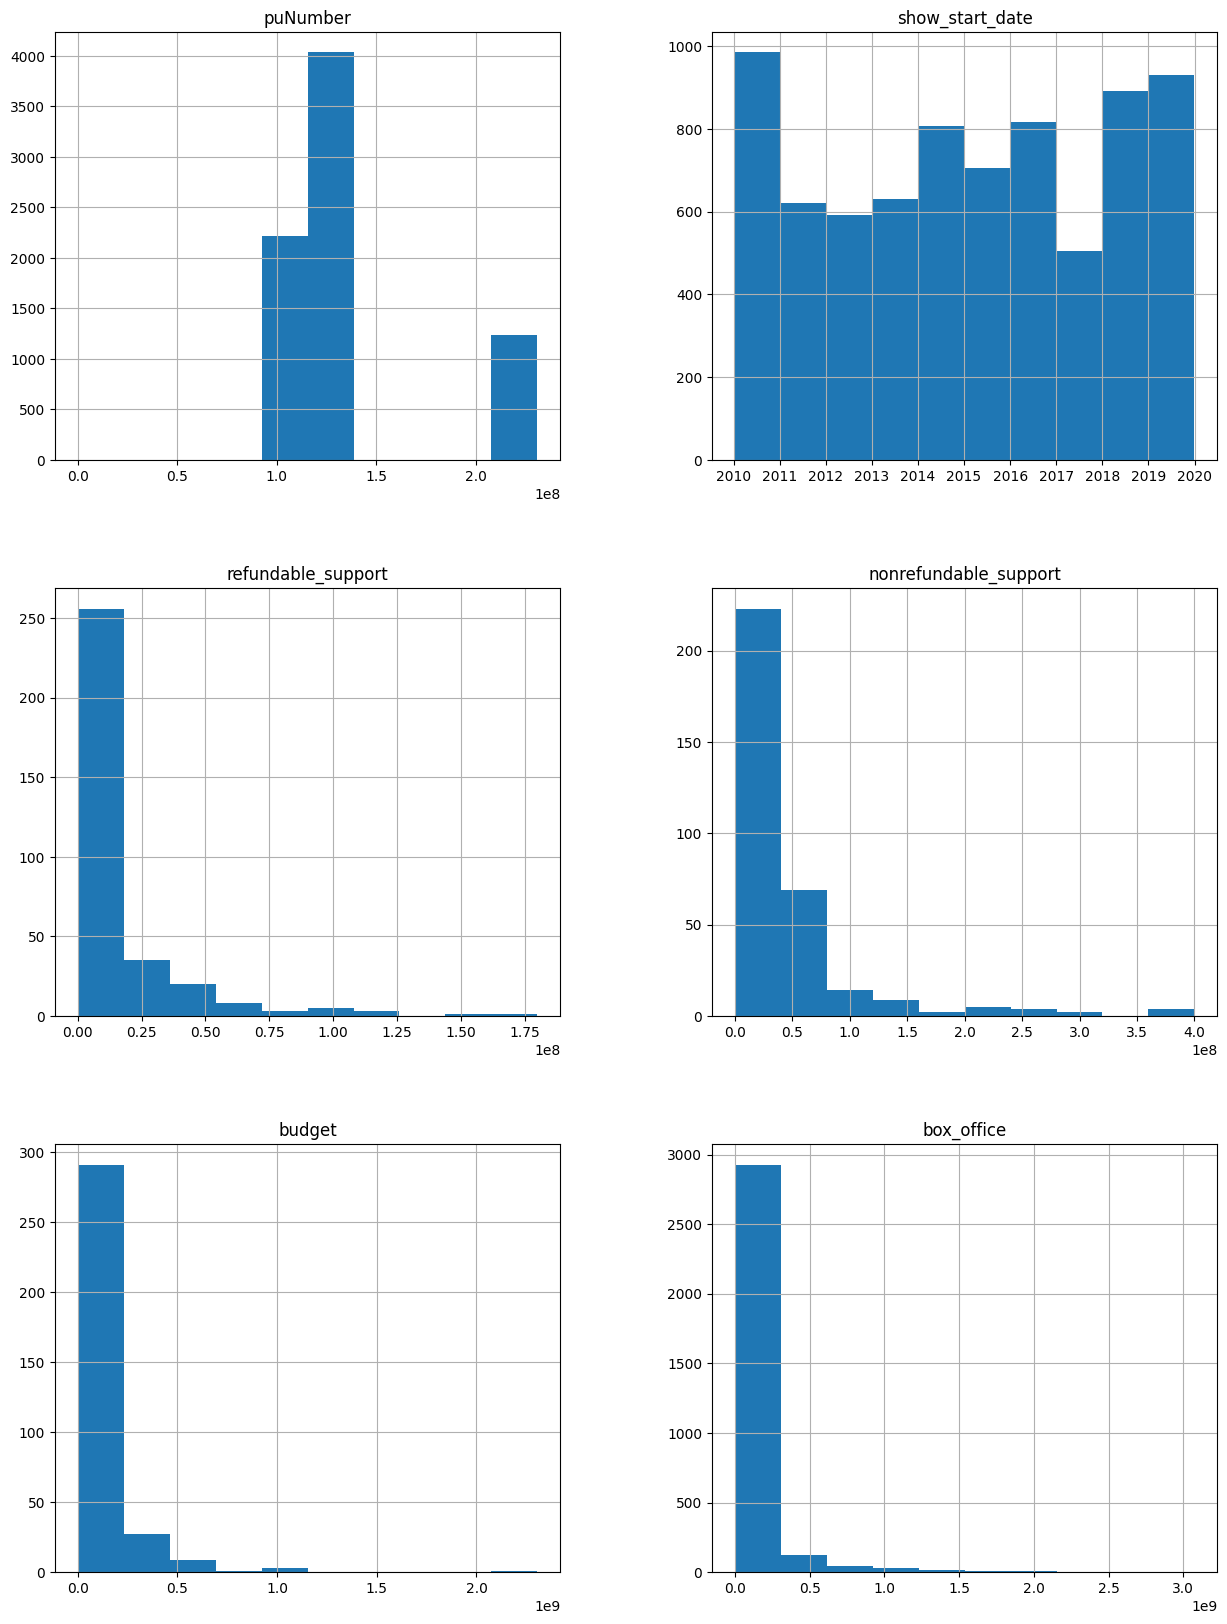

In [34]:
#построение диаграмм
data.hist(figsize=(15,20))
plt.show()

**Заключение:**
- puNumber в основном состоят из единичек, иногде из двоек.  
- Количество фильмов по годам примерно распределено равномерно
- в остальных четырех диаграммах можно заметить множество аномальных значений и основная масса значений расположена у нижней границы.

#### Проверка названий колонок 

Просмотр заголовков таблицы на предмет корректности

In [35]:
print(data.columns)

Index(['title', 'puNumber', 'show_start_date', 'type', 'film_studio',
       'production_country', 'director', 'producer', 'age_restriction',
       'refundable_support', 'nonrefundable_support', 'budget',
       'financing_source', 'ratings', 'genres', 'box_office'],
      dtype='object')


Колонки имеют корректные названия.

### Работа с пропусками

#### Колонка box_office 

Пропуски в этой колонке связаны со слиянием датасетов. Они связаны с тем, что число puNumber в датасете df_movies гораздо больше, чем во втором датасете. Такие пропуски я заполню значением "-1"

In [36]:
data['box_office'].fillna(-1,inplace=True)

In [37]:
needed_cols = ['title','puNumber','director','box_office']
display(data[data['box_office'].isna()][needed_cols].head(10))
print(df_movies[df_movies['puNumber'].isin(df_shows['puNumber'])].shape[0])

,title,puNumber,director,box_office


3158


#### Колонки refundable_support, nonrefundable_support, budget, financing_source.

Проверка на наличие пропусках в одних и тех же строках

In [38]:
data[data['budget'].isna() & 
          data['refundable_support'].isna() &
          data['nonrefundable_support'].isna() &
          data['financing_source'].isna()].shape[0]

7154

Количество строк с условием совпало с количеством пропущенных значений в колонках, поэтому можно заключить, что они в одних и тех же строках. Теперь проверю гипотезу, что пустые колонки связаны с тем, что пропуски в тех фильмах, которые не подлежали гос.поддержке.

In [39]:
display(data[data['budget'].isna() & 
          data['refundable_support'].isna() &
          data['nonrefundable_support'].isna() &
          data['financing_source'].isna() & 
          (data['production_country'].str.contains('Россия')==False)
            ].shape[0])

5499

Подавляющее большинство таких пропусков для фильмов, сделанных без участия России.

Поиск уникальных значений в financing_source:

In [40]:
print(data['financing_source'].unique())

[nan 'Министерство культуры' 'Фонд кино'
 'Министерство культуры, Фонд кино']


**Краткий вывод.**  
Колонки refundable_support, nonrefundable_support, budget, financing_source имеют одинаковое большое количество пропусков (95% от всех значений в соотв. колонках).Вероятными причинами на мой взгляд могут быть:  
- законодательные причины(запрет на публикацию данных органов гос.власти, на разглашение коммерческой информации);  
- данная база данных брала информацию из государственной информационной системы, обслуживающей кинобизнес в России, где эта информация не в открытом доступе;
- можно выдвинуть гипотезу, что иностранные фильмы не подлежали господдержке, а российские фильмы в оставшихся пустых строках были коммерческими и тоже не подлежали господдержке, поэтому система не заполняла данными эти колонки.
Удалять такое огромное количество пропусков неразумно и принял решение:
- в колонках, где бюджет равен 0, заполню их суммой колонок ['refundable_support'] и ['nonrefundable_support']
- заполнить их маркером в виде "-1" в колонках refundable_support, nonrefundable_support, budget  
- в колонке financing_source переименовать пропуски в "неизвестно"

In [41]:
def right_budget(data):
    if data['budget'] == 0:
        data['budget'] = data['refundable_support'] + data['nonrefundable_support']
        return data['budget']
    return data['budget']

In [42]:
display(data[data['budget']==0].head(10)[['budget','refundable_support','nonrefundable_support']])
data['budget'] = data.apply(right_budget,axis=1)
display(data.loc[[3565,5673,5806]][['budget','refundable_support','nonrefundable_support']])

,budget,refundable_support,nonrefundable_support
2053,0.0,0.0,"23,000,000.0"
2058,0.0,0.0,"75,000,000.0"
2472,0.0,"10,000,000.0","70,000,000.0"
2532,0.0,"20,000,000.0",0.0
2615,0.0,"60,000,000.0","100,000,000.0"
2684,0.0,0.0,"59,000,000.0"
2788,0.0,0.0,"35,000,000.0"
2874,0.0,0.0,"6,000,000.0"
3047,0.0,"19,000,000.0","51,000,000.0"
3565,0.0,0.0,"250,000,000.0"


,budget,refundable_support,nonrefundable_support
3565,"250,000,000.0",0.0,"250,000,000.0"
5673,"60,000,000.0","20,000,000.0","40,000,000.0"
5806,"70,000,000.0","10,000,000.0","60,000,000.0"


Проверка на наличие значения "-1" в колонках refundable_support, nonrefundable_support, budget:

In [43]:
data[(data['budget']==-1) | 
     (data['refundable_support']==-1) |
     (data['nonrefundable_support']==-1)]        

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office


Значение "-1" нигде не встречается, поэтому заполним им:

In [44]:
data['budget'].fillna(-1,inplace=True)
data['refundable_support'].fillna(-1,inplace=True)
data['nonrefundable_support'].fillna(-1,inplace=True)
#Проверка
print(
    data['budget'].isna().sum(),
    data['refundable_support'].isna().sum(),
    data['nonrefundable_support'].isna().sum()
)

0 0 0


Заполнение пропусков в financing_source:

In [45]:
data['financing_source'].fillna("неизвестно", inplace=True)
#Проверка
data['financing_source'].isna().sum()

0

#### Работа с  колонкой genres

In [46]:
print('Количество строк, где NaN в обеих колонках: ',data[(data['genres'].isna()) & (data['ratings'].isna())].shape[0])

Количество строк, где NaN в обеих колонках:  967


Так как все пропущенные значения в колонке genres совпадают с пропусками в колонке ratings, я сделаю предположение, что наиболее вероятной причиной являются ошибки в работе автоматизированной системы. Так как пропусков слишком много, их лучше заполнить значением "неизвестно".

In [47]:
data['genres'].fillna('неизвестно', inplace=True)

#### Колонка ratings 

Проверка на количество строк, содержащих нецифровые значения:

In [48]:
display(data[data['ratings'].str.isnumeric()==False].shape[0])

6519

Наиболее вероятными причинами наличия пропусков в этой колонке являются, как и в случае с колонкой genres, отсутствие информации о рейтингах в базе данных, откуда эта система берет информацию; ошибки в работе самой базы данных.
Так как значений много, лучше заполнить их цифровым значением, например нулем, если в базе данных это значение не встречается.

In [49]:
print(data[(data['ratings']==0) | (data['ratings']==0.0)].shape[0])

0


Так как значения нуль в колонке ratings не встречается, то им я заполню пропуски.

In [50]:
data['ratings'].fillna(0,inplace=True)

#### Колонка production_country

Пропуски могли образоваться из-за того, что это сборники мульфильмов, каждый из которых мог иметь свою страну производства и эти значения не могли отследиться базой данных или ее оператором.
В этой колонке имеем два пропуска. В строке 3186 мы можем заполнить значение, найдя информацию сосдених колонках. Так как студией-производителем является ООО "Продюсерский центр ЕРАЛАШ", то можно с уверенностью предположить, что страной будет Россия.  
Во второй строке информацию о стране-производителе также можно найти в сети. С большой долей уверенности можно сказать, что это тоже Россия.

In [51]:
display(data[data['production_country'].isna()])
data['production_country'].fillna('Россия',inplace=True)
print('Количество пропусков после удаления: ',data['production_country'].isna().sum())

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
3186,"Детский юмористический киножурнал ""Ералаш. Ну ...",111001216,2016-02-09 12:00:00+00:00,Художественный,"ООО ""Продюсерский центр ЕРАЛАШ""",NaN,"Р.Светлов, И.Магитон, А.Арутюнян, Л.Мирский, А...","ООО ""Продюсерский центр ЕРАЛАШ""",«0+» - для любой зрительской аудитории,-1.0,-1.0,-1.0,неизвестно,7.2,"детский,комедия","194,527.0"
4441,Мульт личности. Выпуск 5,214000410,2010-01-25 12:00:00+00:00,Художественный,NaN,NaN,NaN,NaN,«0+» - для любой зрительской аудитории,-1.0,-1.0,-1.0,неизвестно,4.0,"мультфильм,комедия",-1.0


Количество пропусков после удаления:  0


#### Работа с колонкой film_studio	

In [52]:
display(data[data['film_studio'].isna()])

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
1293,Stars in Shorts,121011114,2014-06-03 12:00:00+00:00,Художественный,NaN,"США, Великобритания","Роберт Фестингер, Руперт Френд, Джей Камен, Ни...","Татьяна Келли, Роберта Мунро, Руперт Френд, До...",«16+» - для детей старше 16 лет,-1.0,-1.0,-1.0,неизвестно,7.3,комедия,-1.0
4441,Мульт личности. Выпуск 5,214000410,2010-01-25 12:00:00+00:00,Художественный,NaN,Россия,NaN,NaN,«0+» - для любой зрительской аудитории,-1.0,-1.0,-1.0,неизвестно,4.0,"мультфильм,комедия",-1.0
6105,Значит любит,111013818,2018-08-10 12:00:00+00:00,Художественный,NaN,Россия,А.Краевский,Е.Щербакова,«18+» - запрещено для детей,-1.0,-1.0,-1.0,неизвестно,0,неизвестно,-1.0
6181,Несейка. Младшая дочь,112007018,2018-09-01 12:00:00+00:00,Документальный,NaN,Россия,В.Марин,"Д.Якунин, Ф.Абрютин, О.Филонова",«6+» - для детей старше 6 лет,-1.0,-1.0,-1.0,неизвестно,0,неизвестно,-1.0
6379,Ян Антонышев,112011818,2018-11-15 12:00:00+00:00,Документальный,NaN,Россия,Е.Окопная,Е.Герасимов,«12+» - для детей старше 12 лет,-1.0,-1.0,-1.0,неизвестно,0,неизвестно,-1.0
6380,Ян Антонышев,112011918,2018-11-15 12:00:00+00:00,Документальный,NaN,Россия,Е.Окопная,Е.Герасимов,«12+» - для детей старше 12 лет,-1.0,-1.0,-1.0,неизвестно,0,неизвестно,-1.0
6399,Доживем до каникул?..,111021918,2018-11-15 12:00:00+00:00,Художественный,NaN,Россия,Я.Хальпукова (псевдоним Яна Мартынец),Я.Хальпукова (псевдоним Яна Мартынец),«12+» - для детей старше 12 лет,-1.0,-1.0,-1.0,неизвестно,0,неизвестно,"41,225.0"
6485,До и После,112014418,2018-12-05 12:00:00+00:00,Документальный,NaN,Россия,А.Новокреповская,А.Новокреповская,«6+» - для детей старше 6 лет,-1.0,-1.0,-1.0,неизвестно,6.9,"драма,криминал,детектив",-1.0
6494,Калмыцкий геше Нгаванг Вангьял,113002018,2018-12-05 12:00:00+00:00,Научно-популярный,NaN,Россия,И.Долгина,И.Долгина,«12+» - для детей старше 12 лет,-1.0,-1.0,-1.0,неизвестно,0,неизвестно,-1.0
6497,Мой папа Чингисхан,112014918,2018-12-06 12:00:00+00:00,Документальный,NaN,Россия,А.Сайфуллина,А.Сайфуллина,«12+» - для детей старше 12 лет,-1.0,-1.0,-1.0,неизвестно,0,неизвестно,-1.0


Так как пропусков всего 18, на мой взгляд, они  вызваны или незанесением этой информации в базу данных ее оператором, или сбоем самой системы, или ее как таковой не было. Пропущенные значения можно заполнить значением "неизвестно"

In [53]:
data['film_studio'].fillna('неизвестно',inplace=True)

#### Работа с колонкой director

Эта колонка имеет  9 пропусков.Выводу информацию, где в колонке director пропуски, а в колонке producer нет пропусков:

In [54]:
display(data[(data['director'].isna()) & (data['producer'].notna())])

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
764,"Три звезды. Концерт в Waldbuhne Theater, Берли...",126003512,2012-12-04 12:00:00+00:00,Прочие,Райзинг Алтернатив,Великобритания,NaN,Вальдбюне Театр,«0+» - для любой зрительской аудитории,-1.0,-1.0,-1.0,неизвестно,0,неизвестно,"44,350.0"
1735,Помпеи. Британский музей,126003413,2013-09-11 12:00:00+00:00,Прочие,"МортуСкрин, Британский музей",Великобритания,NaN,Британский музей,«0+» - для любой зрительской аудитории,-1.0,-1.0,-1.0,неизвестно,0,неизвестно,-1.0
4415,Bon Jovi. The Circle Tour,126001710,2010-11-11 12:00:00+00:00,Прочие,Эншутц Интертейнмент Груп,США,NaN,Эншутц Интертейнмент Груп,«0+» - для любой зрительской аудитории,-1.0,-1.0,-1.0,неизвестно,7.9,"концерт,музыка",-1.0
4923,Георг Фридрих Гендель. Мессия. Оратория. Корол...,126001111,2011-04-25 12:00:00+00:00,Прочие,Опус Арт,Великобритания,NaN,Короевский колледж Кембриджа,«0+» - для любой зрительской аудитории,-1.0,-1.0,-1.0,неизвестно,0,неизвестно,-1.0
4942,Питер Гэбриэл и New Blood Orchestra 3D,126002711,2011-11-11 12:00:00+00:00,Прочие,Омниверс Визион,Великобритания,NaN,Омниверс Визион,«0+» - для любой зрительской аудитории,-1.0,-1.0,-1.0,неизвестно,6.7,"концерт,музыка",-1.0


Оставшиеся 4 пропуска в колонке director приходятся на строки, где колонка producer содержит NaN. Так как строк всего 5, пропуски можно заполнить, найдя недостающую информацию в сети.   
Для строки 1735 - режиссер Джон Руни.  
Для строки 4942 - режиссер Блу Лич.  
Для остальных строк информации найти не удалось и пропускам присвою значение "неизвестно".

In [55]:
data.loc[1735,'director'] = 'Джон Руни'
data.loc[4942,'director'] = 'Блу Лич'
data['director'].fillna('неизвестно',inplace=True)

#### Работа с колонкой producer. 

Эта колонка имеет  568 пропусков.Так какв киноиндустрии часто режиссеры фильмов выступают в качестве продюссеров и наоборот, пропуски в этой колонке можно попытаться заполнить значениями из другой.Также может пригодиться колонка film_studio.

In [56]:
print('Количество строк, где директор есть, а продюсер неизвестен: ',data[(data['director'].notna()) & (data['producer'].isna())].shape[0])
print('Количество строк, где страна-производитель - CCCР и продюсер неизвестен: ', data[(data['production_country'].str.contains("СССР"))  & (data['producer'].isna())].shape[0])
print('Количество строк, где директор и продюсер совпадают: ',(data[data['director']==data['producer']].shape[0]))
print('Количество строк, где страна-производитель - CCCР, а продюсер и директор совпадают : ', data[(data['production_country'].str.contains("СССР"))  & (data['producer']==data['director'])].shape[0])
display(data.query('production_country.str.contains("СССР") and producer.notna()')[['production_country','film_studio','director','producer']])
print(data.query('production_country.str.contains("СССР")')['producer'].value_counts())

Количество строк, где директор есть, а продюсер неизвестен:  568
Количество строк, где страна-производитель - CCCР и продюсер неизвестен:  394
Количество строк, где директор и продюсер совпадают:  329
Количество строк, где страна-производитель - CCCР, а продюсер и директор совпадают :  1


,production_country,film_studio,director,producer
3093,"СССР, Россия","Киностудия ""Мосфильм"", ФГУП ""Киноконцерн ""Мосф...","С.Эйзенштейн, Д.Васильев","ФГУП ""Киноконцерн ""Мосфильм"""
3193,"СССР, Россия","Киностудия ""Мосфильм"", ЗАО ""Киновидеообъединен...",Э.Рязанов,"ЗАО ""Киновидеообъединение ""Крупный план"", ООО ..."
3926,СССР,ИП Аболс А.Р.,А.Аболс,А.Аболс
3931,СССР,ИП Аболс А.Р.,"К.Котельников, А.Аболс",А.Аболс
3962,"СССР, Россия","Киностудия ""Ленфильм"", ЗАО ""Киновидеообъединен...",И.Цветов (режиссер ч/б фильма - С.Тимошенко),"ЗАО ""Киновидеообъединение ""Крупный план"""
4008,СССР - Италия,"Киностудия ""Мосфильм"" при участии ""ДИНО ДЕ ЛАУ...",Ю.Озеров,"ФГУП ""Киноконцерн ""Мосфильм"""
4009,СССР - Италия,"Киностудия ""Мосфильм"" при участии ""ДИНО ДЕ ЛАУ...",Ю.Озеров,"ФГУП ""Киноконцерн ""Мосфильм"""
4010,СССР - ГДР - Польша - Италия,"Киностудия ""Мосфильм"" при участии ""ДЕФА"", кино...","Ю.Озеров, Ю.Бондарев","ФГУП ""Киноконцерн ""Мосфильм"""
4011,СССР - ГДР - Польша - Италия,"Киностудия ""Мосфильм"" при участии ""ДЕФА"", кино...","Ю.Озеров, Ю.Бондарев","ФГУП ""Киноконцерн ""Мосфильм"""
4012,СССР - ГДР - Польша - Италия,"Киностудия ""Мосфильм"" при участии ""ДЕФА"", кино...","Ю.Озеров, Ю.Бондарев","ФГУП ""Киноконцерн ""Мосфильм"""


ФГУП "Киноконцерн "Мосфильм"                                      8
А.Аболс                                                           2
 ФГУП "Киноконцерн "Мосфильм"                                     1
ЗАО "Киновидеообъединение "Крупный план"                          1
ЗАО "Киновидеообъединение "Крупный план", ООО "Формула цвета"     1
Name: producer, dtype: int64


Из таблички выше можно предположить, что там, где в film_studio указан "Мосфильм", в колонке producer будет фигурировать ФГУП "Киноконцерн "Мосфильм". Также следует отметить наличие неявного дубликата в ФГУП "Киноконцерн "Мосфильм" (пробел спереди).

In [57]:
print(data[(data['film_studio'].str.contains('Мосфильм'))
           & (data['producer'].isna()) 
           & (data['production_country'].str.contains("СССР"))].shape[0])

371


Таких строк набралось 371, поэтому я предположу. что если фильм выпущен в СССР, известно, на какой студии его снимали, то пропуски в колонке producer можно заполнить значением в колонке film_studio.

In [58]:
data.loc[(data['film_studio'].notna())
           & (data['producer'].isna()) 
           & (data['production_country'].str.contains("СССР")),'producer'] = data['film_studio']

In [59]:
display(data[data['producer'].isna()].shape[0])

174

Оставшиеся 174 пропуска я заполню значением "неизвестно", так как я не могу с уверенностью предположить, для фильмов, не выпущенных в СССР, действует та же самая гипотеза, что я применил выше.

In [60]:
data['producer'].fillna("неизвестно",inplace=True)

### Работа с дубликатами

Проверка на количество одинаковых строк:  

In [61]:
print(data.duplicated().sum())   

0


#### Колонка puNumber 

In [62]:
#Проверка на повторения
df_tmp = data.groupby('puNumber')['puNumber'].count()
print(df_tmp.sort_values(ascending=False))
display(data[(data['puNumber']==221054410) | (data['puNumber']==221154310)])

puNumber
221054410    2
221154310    2
0            1
121029214    1
121029319    1
            ..
121002912    1
121002911    1
121002910    1
121002819    1
231001111    1
Name: puNumber, Length: 7484, dtype: int64


,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
4638,Как жениться и остаться холостым,221154310,2010-12-17 12:00:00+00:00,Художественный,"Ше Вам, Скрипт Ассосье, Тэ Фэ 1 Фильм Продюксь...",Франция,Эрик Лартиго,"Амандин Било, Алан Шаба",«16+» - для детей старше 16 лет,-1.0,-1.0,-1.0,неизвестно,7.0,"мелодрама,комедия",-1.0
4639,Иоанна - женщина на папском престоле /По роман...,221154310,2010-12-17 12:00:00+00:00,Художественный,"Константин Фильм, А Эр Ди Дегето Фильм, Дюне ...",Германия - Великобритания - Италия - Испания,Зенке Вортманн,"Оливер Бербен, Дорис Д.Хайнце, Фарук Элтан",«16+» - для детей старше 16 лет,-1.0,-1.0,-1.0,неизвестно,7.6,"драма,мелодрама,история",-1.0
5067,Анализируй это!,221054410,2010-05-25 12:00:00+00:00,Художественный,"Уорнер Бразерс, Вилладж Роудшоу Филмз ЛТД",США-Австралия,ХЭрольд Рэмис,"Джейн Розенталь, Пола Уейнстейн",«16+» - для детей старше 16 лет,-1.0,-1.0,-1.0,неизвестно,7.4,"комедия,криминал",-1.0
5068,Анализируй то!,221054410,2010-05-25 12:00:00+00:00,Художественный,"Уорнер Бразерс, Виллидж Роадшоу Пикчерз, Эн-Пи...",США,Гарольд Реймис,"Джейн Розенталь, Паул Уэйнстейн",«12+» - для детей старше 12 лет,-1.0,-1.0,-1.0,неизвестно,6.8,"комедия,криминал",-1.0


**Краткий вывод.**  
Изучение этих строк, а также базы данных кинопоиска, дает основание полагать, что это все разные фильмы. Причиной этих дубликатов является, мне кажется, человеческий фактор.
Так как по условию проекта,  фильм может иметь несколько прокатных удостоверений, но последнее не может распространяться на несколько фильмов, я принял решение присвоить им разные значения в рамках проекта. Так как нуль означает отсутствие удостоверения, то присвою им уникальные значения.

In [63]:
display(data.query('puNumber==-222222222 or puNumber==-333333333'))


,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office


Так как таких значений нет в базе данных, присвою их:

In [64]:
data.loc[4639,'puNumber'] = (-222222222)
df_movies.loc[5068,'puNumber'] = (-333333333)

#### Колонка type

Нахождение уникальных значений

In [65]:
print(data['type'].unique())

['Художественный' 'Анимационный' 'Прочие' 'Документальный'
 'Научно-популярный' ' Художественный' ' Анимационный'
 'Музыкально-развлекательный']


Удаление левого пробела:

In [66]:
data['type'] = data['type'].apply(lambda x:x.lstrip())
print(data['type'].unique())

['Художественный' 'Анимационный' 'Прочие' 'Документальный'
 'Научно-популярный' 'Музыкально-развлекательный']


#### Колонка title 

In [67]:
#Функция для вывода  списков более 1000 элементов в юпитере без многоточий
def print_long_lists(lst):
    count=0
    n=1
    while count<len(lst):
        print(lst[count:n*1000],end=' ')        
        count+=1000
        n+=1
        if count==len(lst):
            print(lst[-1])
    else:
        print('\nКонец списка, количество элементов: ',len(lst))    


Поиск уникальных имен:

In [68]:

title_unique = data['title'].sort_values().unique()
print('Длина списка уникальных имен',len(title_unique))

Длина списка уникальных имен 6772


Подсчет дубликатов:

In [69]:
print('Количество дубликатов в колонке: ',data['title'].duplicated().sum())
print(data.groupby('title')['title'].count().sort_values(ascending=False))

Количество дубликатов в колонке:  714
title
День святого Валентина_          5
Там, где живут чудовища          4
Рапунцель: Запутанная история    4
Дом грёз                         4
Белоснежка и охотник             4
                                ..
Исправленному верить             1
Исполнительный лист              1
Исполнение желаний.              1
Исповедь содержанки              1
сНежное шоу                      1
Name: title, Length: 6772, dtype: int64


Более внимательный осмотр:

In [70]:
display(data[data['title'].str.contains('Гарри Поттер')].sort_values('title'))
display(data[data['title'].isin(['Волшебная страна','Хаббл 3D','Прощание','Багровый пик','Остров лемуров'])].sort_values('title')[['title','box_office','show_start_date','film_studio','director','ratings']])

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
5057,Гарри Поттер и Дары Смерти - Часть 1/По роману...,221068911,2011-05-18 12:00:00+00:00,Художественный,"Уорнер Бразерс, Хэйдэй Филмз",США - Великобритания,Дэвид Йейтс,"Дейвид Баррон, Дейвид Хейман",«16+» - для детей старше 16 лет,-1.0,-1.0,-1.0,неизвестно,8.1,"фэнтези,драма,детектив",-1.0
4526,Гарри Поттер и Дары Смерти - Часть 1/По роману...,221144910,2010-12-10 12:00:00+00:00,Художественный,"Уорнер Бразерс, Хэйдэй Филмз",США - Великобритания,Дэвид Йейтс,"Дейвид Баррон, Дейвид Хейман",«16+» - для детей старше 16 лет,-1.0,-1.0,-1.0,неизвестно,8.1,"фэнтези,драма,детектив",-1.0
4198,Гарри Поттер и Дары Смерти - Часть 1/По роману...,121021010,2010-11-11 12:00:00+00:00,Художественный,"Уорнер Бразерс, Хэйдэй Филмз",США - Великобритания,Дэвид Йейтс,"Дейвид Баррон, Дейвид Хейман",«16+» - для детей старше 16 лет,-1.0,-1.0,-1.0,неизвестно,8.1,"фэнтези,драма,детектив","1,700.0"
371,Гарри Поттер и Дары Смерти - Часть 1/По роману...,121026516,2016-09-23 12:00:00+00:00,Художественный,"Уорнер Бразерс, Хэйдэй Филмз",США - Великобритания,Дэвид Йейтс,"Дейвид Баррон, Дейвид Хейман",«16+» - для детей старше 16 лет,-1.0,-1.0,-1.0,неизвестно,8.1,"фэнтези,драма,детектив","745,510.0"
4872,Гарри Поттер и Дары Смерти - Часть 2 /По роман...,121011611,2011-07-06 12:00:00+00:00,Художественный,"Хэйдей Филмз, Мувинг Пикчер Компани, Уорнер Бр...",США - Великобритания,Дэвид Йетс,"Дэвид Баррон, Дэвид Хейман",«16+» - для детей старше 16 лет,-1.0,-1.0,-1.0,неизвестно,8.1,"фэнтези,драма,детектив","9,000.0"
395,Гарри Поттер и Дары Смерти - Часть 2 /По роман...,121026616,2016-09-23 12:00:00+00:00,Художественный,"Хэйдей Филмз, Мувинг Пикчер Компани, Уорнер Бр...",США - Великобритания,Дэвид Йетс,"Дэвид Баррон, Дэвид Хейман",«16+» - для детей старше 16 лет,-1.0,-1.0,-1.0,неизвестно,8.1,"фэнтези,драма,детектив","1,017,220.0"
337,Гарри Поттер и Принц-полукровка /По роману Дж....,121026416,2016-09-23 12:00:00+00:00,Художественный,"Уорнер Бразерс, Хэйдэй Филмз",США - Великобритания,Дэвид Йейтс,Дэйвид Хейман,«12+» - для детей старше 12 лет,-1.0,-1.0,-1.0,неизвестно,7.7,"фэнтези,приключения,семейный","883,640.0"
4428,Гарри Поттер и Принц-полукровка /По роману Дж....,221134610,2010-11-29 12:00:00+00:00,Художественный,"Уорнер Бразерс, Хэйдэй Филмз",США - Великобритания,Дэвид Йейтс,Дэйвид Хейман,«12+» - для детей старше 12 лет,-1.0,-1.0,-1.0,неизвестно,7.7,"фэнтези,приключения,семейный",-1.0
121,Гарри Поттер и кубок огня /По роману Дж.К.Ролинг/,221004816,2016-02-09 12:00:00+00:00,Художественный,"Уорнер Бразерс, Хэйдэй Филмз",США - Великобритания,Майк Ньюэлл,Дэйвид Хейман,«16+» - для детей старше 16 лет,-1.0,-1.0,-1.0,неизвестно,7.9,"фэнтези,приключения,семейный",-1.0
122,Гарри Поттер и кубок огня /По роману Дж.К.Ролинг/,121026216,2016-09-23 12:00:00+00:00,Художественный,"Уорнер Бразерс, Хэйдэй Филмз",США - Великобритания,Майк Ньюэлл,Дэйвид Хейман,«16+» - для детей старше 16 лет,-1.0,-1.0,-1.0,неизвестно,7.9,"фэнтези,приключения,семейный","843,310.0"


,title,box_office,show_start_date,film_studio,director,ratings
2608,Багровый пик,"1,200.0",2016-06-10 12:00:00+00:00,Леджендари Пикчерз,Гильермо дель Торо,6.6
2609,Багровый пик,-1.0,2016-02-19 12:00:00+00:00,Леджендари Пикчерз,Гильермо дель Торо,6.6
2610,Багровый пик,"294,842,966.0",2015-07-23 12:00:00+00:00,Леджендари Пикчерз,Гильермо дель Торо,6.6
107,Волшебная страна,-1.0,2016-02-09 12:00:00+00:00,Филм Колони,Марк Форстер,7.9
4653,Волшебная страна,-1.0,2010-12-17 12:00:00+00:00,Филм Колони,Марк Форстер,7.9
266,Прощание,-1.0,2014-12-24 12:00:00+00:00,"Киностудия ""Мосфильм""",Э.Климов,7.2
5514,Прощание,-1.0,2017-09-07 12:00:00+00:00,Всероссийский государственный институт кинемат...,А.Петровская,7.2
6909,Прощание,-1.0,2019-05-01 12:00:00+00:00,ИП Киселев Алексей Евгеньевич,М.Фомина,7.2
7281,Прощание,"2,617,932.5",2019-10-07 12:00:00+00:00,"Биг Бич Филмз, Депз оф Филд, Киндред Спирит",Лулу Ванг,7.2
4301,Хаббл 3D,"245,630.0",2010-09-23 12:00:00+00:00,"Аймакс Спейс, Уорнер Бразерс",Тони Майерс,7.6


In [71]:
display(data.loc[data['title'].isin(
    ['День святого Валентина','Там, где живут чудовища','Рапунцель: Запутанная история','Дом грёз','Белоснежка и охотник']
)].sort_values('title').sort_values('box_office',ascending=False)[['title','box_office','show_start_date','director','ratings']])


,title,box_office,show_start_date,director,ratings
446,Белоснежка и охотник,"470,427.0",2012-05-25 12:00:00+00:00,Руперт Сандерс,6.0
4378,Рапунцель: Запутанная история,"17,055.0",2010-11-23 12:00:00+00:00,"Натан Грино, Байрон Ховард",7.9
445,Белоснежка и охотник,-1.0,2016-06-29 12:00:00+00:00,Руперт Сандерс,6.0
447,Белоснежка и охотник,-1.0,2012-07-17 12:00:00+00:00,Руперт Сандерс,6.0
448,Белоснежка и охотник,-1.0,2012-12-11 12:00:00+00:00,Руперт Сандерс,6.0
385,Дом грёз,-1.0,2015-02-25 12:00:00+00:00,Джим Шеридан,7.6
386,Дом грёз,-1.0,2012-04-26 12:00:00+00:00,Джим Шеридан,7.6
5085,Дом грёз,-1.0,2011-09-21 12:00:00+00:00,Джим Шеридан,7.6
5340,Дом грёз,-1.0,2011-11-11 12:00:00+00:00,Джим Шеридан,7.6
378,Рапунцель: Запутанная история,-1.0,2014-10-10 12:00:00+00:00,"Натан Грино, Байрон Ховард",7.9


**Краткий вывод.**  
Причиной образования дубликатов в этой колонке является возможность того, что фильм может иметь несколько прокатных удостоверений. Соответственно. когда одна база данных брала информацию от другой базы данных, они не делали проверку на совпадение названий. Также возможно, что фильмы имели несколько премьер в России, отсюда и их разные кассовые сборы. Причиной также могут быть критерии, по каким кассовые сборы попадают в базу данных.
Рассмотрев вышеприведенные таблички, я пришел заключению, что способом удаления дубликатов будет следующий порядок:  
- сначала сортировка датафрейма по именам в возрастающем порядке;  
- сортировка по кассовым сборам в убывающем порядке;
- применение drop_duplicates c проверкой по колонкам title, box_office,рейтинг, директор, с оставлением первого значения;
- применение drop() для удаления строк с условием, что они дубликаты по имени и box_office меньше нуля

Удаление пробелов и других знаков:

In [72]:

data['title'] = data['title'].str.strip().str.strip(',').str.strip('_').str.strip('.').str.strip('  ').str.replace('#',' ')
title_unique = data['title'].sort_values().unique()
print(len(title_unique))
print(data['title'].duplicated().sum())

6681
805


Удаление дубликатов имен: 

In [73]:
data = data.sort_values('title').sort_values('box_office',ascending=False).drop_duplicates(
    subset=['title','ratings','box_office','director'])
data = data[(data['title'].duplicated()==False) & data['box_office']!=(-1.0)]
print(data['title'].duplicated().sum())

295


Проверочная информация:

In [74]:

print(data.groupby('title')['title'].count().sort_values(ascending=False))
display(data.loc[data['title'].isin(
    ['День святого Валентина','Там, где живут чудовища','Рапунцель: Запутанная история',
     'Дом грёз','Белоснежка и охотник','Хаббл 3D','Прощание','Волшебная страна']
)].sort_values('title')[['title','box_office','show_start_date','director','ratings']])
display(data[data['title'].str.contains('Гарри Поттер')].sort_values('title')[['title','box_office','show_start_date','director','ratings']])
display(data[data['title'].isin(['Волшебная страна','Прощание','Багровый пик','Остров лемуров','Успех','Вторжение','Гадкий Я'])].sort_values('title')[['title','box_office','show_start_date','director','ratings']])

title
Хаббл 3D                                                       4
Прощание                                                       4
Волшебная страна                                               4
Гарри Поттер и Дары Смерти - Часть 1/По роману Дж.К.Ролинг/    3
Лесной патруль                                                 3
                                                              ..
Интимный дневник                                               1
Интимные места                                                 1
Интерстеллар                                                   1
Интердевочка                                                   1
сНежное шоу                                                    1
Name: title, Length: 6681, dtype: int64


,title,box_office,show_start_date,director,ratings
447,Белоснежка и охотник,-1.0,2012-07-17 12:00:00+00:00,Руперт Сандерс,6.0
446,Белоснежка и охотник,"470,427.0",2012-05-25 12:00:00+00:00,Руперт Сандерс,6.0
2120,Волшебная страна,"1,171,085.6",2015-02-05 12:00:00+00:00,Фанг Лей,7.9
937,Волшебная страна,"20,260.0",2013-04-15 12:00:00+00:00,"Мартин Клэпп, Дорота Кобеля, Джофф Линдси",7.9
936,Волшебная страна,"3,750.0",2016-06-07 12:00:00+00:00,"Мартин Клэпп, Дорота Кобеля, Джофф Линдси",7.9
4653,Волшебная страна,-1.0,2010-12-17 12:00:00+00:00,Марк Форстер,7.9
3902,День святого Валентина,-1.0,2010-07-15 12:00:00+00:00,Гарри Маршалл,6.7
5085,Дом грёз,-1.0,2011-09-21 12:00:00+00:00,Джим Шеридан,7.6
266,Прощание,-1.0,2014-12-24 12:00:00+00:00,Э.Климов,7.2
6909,Прощание,-1.0,2019-05-01 12:00:00+00:00,М.Фомина,7.2


,title,box_office,show_start_date,director,ratings
4526,Гарри Поттер и Дары Смерти - Часть 1/По роману...,-1.0,2010-12-10 12:00:00+00:00,Дэвид Йейтс,8.1
4198,Гарри Поттер и Дары Смерти - Часть 1/По роману...,"1,700.0",2010-11-11 12:00:00+00:00,Дэвид Йейтс,8.1
371,Гарри Поттер и Дары Смерти - Часть 1/По роману...,"745,510.0",2016-09-23 12:00:00+00:00,Дэвид Йейтс,8.1
4872,Гарри Поттер и Дары Смерти - Часть 2 /По роман...,"9,000.0",2011-07-06 12:00:00+00:00,Дэвид Йетс,8.1
395,Гарри Поттер и Дары Смерти - Часть 2 /По роман...,"1,017,220.0",2016-09-23 12:00:00+00:00,Дэвид Йетс,8.1
4428,Гарри Поттер и Принц-полукровка /По роману Дж....,-1.0,2010-11-29 12:00:00+00:00,Дэвид Йейтс,7.7
337,Гарри Поттер и Принц-полукровка /По роману Дж....,"883,640.0",2016-09-23 12:00:00+00:00,Дэвид Йейтс,7.7
121,Гарри Поттер и кубок огня /По роману Дж.К.Ролинг/,-1.0,2016-02-09 12:00:00+00:00,Майк Ньюэлл,7.9
122,Гарри Поттер и кубок огня /По роману Дж.К.Ролинг/,"843,310.0",2016-09-23 12:00:00+00:00,Майк Ньюэлл,7.9
4427,Гарри Поттер и орден Феникса /По роману Дж.К.Р...,-1.0,2010-11-29 12:00:00+00:00,Дэвид Йетс,7.7


,title,box_office,show_start_date,director,ratings
2610,Багровый пик,"294,842,966.0",2015-07-23 12:00:00+00:00,Гильермо дель Торо,6.6
2609,Багровый пик,-1.0,2016-02-19 12:00:00+00:00,Гильермо дель Торо,6.6
2608,Багровый пик,"1,200.0",2016-06-10 12:00:00+00:00,Гильермо дель Торо,6.6
936,Волшебная страна,"3,750.0",2016-06-07 12:00:00+00:00,"Мартин Клэпп, Дорота Кобеля, Джофф Линдси",7.9
4653,Волшебная страна,-1.0,2010-12-17 12:00:00+00:00,Марк Форстер,7.9
2120,Волшебная страна,"1,171,085.6",2015-02-05 12:00:00+00:00,Фанг Лей,7.9
937,Волшебная страна,"20,260.0",2013-04-15 12:00:00+00:00,"Мартин Клэпп, Дорота Кобеля, Джофф Линдси",7.9
4550,Вторжение,-1.0,2010-12-15 12:00:00+00:00,"Оливер Хиршбигель, Джеймс МакТиг",5.7
7474,Вторжение,-1.0,2019-12-23 12:00:00+00:00,Ф.Бондарчук,5.7
5430,Вторжение,-1.0,2017-08-01 12:00:00+00:00,Эрик Дарнелл,5.7


Выборочное удаление строк:

In [75]:
data = data.loc[data.index.drop([2609,4526,4770,4761,447,4429,4427,121,4428,4193,4192,4488])]
print(data['title'].duplicated().sum())

283


#### Колонка genres

Поиск уникальных имен, подсчет дубликатов:

In [76]:
genres_unique = data['genres'].sort_values().unique()
print('Длина списка уникальных имен',len(genres_unique))
print('Количество дубликатов в колонке: ', data['genres'].duplicated().sum())

Длина списка уникальных имен 743
Количество дубликатов в колонке:  6221


Дубликаты в этой колонке вызваны тем, что фильмов очень много. а жанров относительно мало, отсюда множество повторений.

Удаление пробелов и прочих знаков, приведение к нижнему регистру:

In [77]:
data['genres'] = data['genres'].str.strip().str.lower().str.strip(',').str.strip('_').str.strip('.').str.strip('  ')
print(data['genres'].duplicated().sum())

6221


In [78]:
#Функция для обработки дубликатов
def find_duplicates_base(lst):
    sorted_tmp1 = [] # список уникальных строк
    sorted_tmp2 = [] #список строк-дубликатов
    filtered_genres = [] #список слов в каждой строке-дубликате
    for element in lst:
        #Приведение строк в отсортированный вид
        sorted_string = sorted(element)
        #Строки считаются идентичными, если равны их отсортированные версии
        if sorted_string not in sorted_tmp1:
            sorted_tmp1.append(sorted_string)
        else:
            sorted_tmp2.append(element)    
    for ele in sorted_tmp2:               
        words = [word.lower() for word in ele.split(',')]
        #сортировка слов в списке по алфавиту
        sorted_order = sorted(words)
        if sorted_order not in filtered_genres:
            filtered_genres.append(sorted_order)    
    res = [','.join (_ele) for _ele in filtered_genres]
    return res   


Вывод строк-дубликатов, отcортированных по алфавиту:

In [79]:
duplicated_genres = find_duplicates_base(genres_unique)
print(duplicated_genres,len(duplicated_genres))

['биография,военный,драма', 'биография,драма,история', 'биография,драма,криминал', 'боевик,военный,драма', 'боевик,драма,история', 'боевик,драма,криминал', 'боевик,драма,триллер', 'боевик,криминал,триллер', 'боевик,приключения,триллер', 'боевик,вестерн,драма', 'боевик,вестерн,приключения', 'боевик,военный,история', 'военный,драма,история', 'боевик,детектив,криминал', 'детектив,драма,криминал', 'боевик,детектив,триллер', 'детектив,драма,триллер', 'детектив,криминал,триллер', 'биография,документальный', 'биография,документальный,музыка', 'биография,документальный,спорт', 'биография,драма', 'биография,драма,музыка', 'биография,драма,спорт', 'боевик,драма', 'боевик,драма,приключения', 'военный,драма', 'военный,драма,приключения', 'детектив,драма,история', 'детектив,драма,приключения', 'биография,драма,комедия', 'военный,драма,комедия', 'детектив,драма,комедия', 'биография,драма,мелодрама', 'драма,комедия,мелодрама', 'драма,мелодрама,приключения', 'драма,комедия,семейный', 'боевик,драма,спо

In [80]:
display(data[data['genres'].str.contains('биография') 
             & data['genres'].str.contains('драма') 
             & data['genres'].str.contains('военный') ]['genres'].head(5))

2132    биография,военный,драма
3265    драма,военный,биография
3503    драма,военный,биография
7192    биография,драма,военный
6761    драма,военный,биография
Name: genres, dtype: object

Так как потом будет задание на главный жанр, я не стал приводить их в отсортированный вид.

In [81]:
print(len(genres_unique))

743


#### Колонка film_studio

Поиск уникальных имен, подсчет дубликатов:

In [82]:
studio_unique = data['film_studio'].sort_values().unique()
print('Длина списка уникальных имен',len(studio_unique))
print('Количество дубликатов в колонке: ',data['film_studio'].duplicated().sum())
print_long_lists(studio_unique)

Длина списка уникальных имен 5478
Количество дубликатов в колонке:  1486
[' АНО "Кинофорум"' ' Ауматик Интертейнмент, Блюмхаус Продакшнз и др.'
 ' ЗАО "Кинокомпания ФаворитФильм" по заказу ООО "ФАВОРИТ МЕДИА"'
 ' Константин Фильм, А Эр Ди Дегето Фильм, Дюне Филис, Икури Филмз, Медуза Фильм, У Эф А Интернэшнл Филм энд Ти Ви Продуцион, Юниверсум Филм '
 ' ООО "АВАТАРА"' ' ООО "КОСТАФИЛЬМ"' ' ООО "КиноФирма"'
 ' ООО "Кинокомпания "Студия ПРЕССИНГ"' ' ООО "Магнум-фильм"'
 ' ООО "Продюсерская фирма Игоря Толстунова"' ' ООО "Студия "Рой"'
 ' ООО "Студия 25", ООО "Медиа Арт Студио", ООО "Продюсерский центр "Синема Продакшн" '
 ' ООО "Студия МЕТРАФИЛЬМС", Компания "TASSE film", Компания "SIRENA film"'
 ' ООО "ТаББаК"' ' ООО "ТаББаК", ООО "Анимационная студия "Москва"'
 ' ООО "ТаББаК", ООО "Весёлая Компания"' ' ООО "Форс Медиа"'
 ' ООО "Хардкор", ООО "Патриот продакшнс"' ' ООО "Энджой мувиз"'
 ' ООО "Энджой мувиз", ООО "Эмоушен Пикчерз", ООО "РЕНОВАЦИО интертейнмент"'
 ' ООО Продюсерский центр 

In [83]:
display(data[data['film_studio'].duplicated() & data['production_country'].str.contains('СССР')].shape[0])

359

Наличие дубликатов в этой колонке связано с наличием крупных киностудий, которые выпускают фильмы в массовом порядке, также четверть  дубликатов приходится на СССР, где существовало несколько крупных студий, которые выпускали фильмы.

Удаление пробелов и прочих знаков:

In [84]:
data['film_studio'] = data['film_studio'].str.strip().str.strip(',').str.strip('_').str.strip('.').str.strip('  ')
print(data['film_studio'].duplicated().sum())

1516


#### Колонка production_country

Поиск уникальных имен, подсчет дубликатов:

In [85]:
country_unique = data['production_country'].sort_values().unique()
print('Длина списка уникальных имен',len(country_unique))
print('Количество дубликатов в колонке: ',data['production_country'].duplicated().sum())
print_long_lists(country_unique)

Длина списка уникальных имен 948
Количество дубликатов в колонке:  6016
[' СССР' ' СССР ' ' СССР   ' '2019' 'CША' 'Австралия'
 'Австралия - Великобритания - Бельгия - Индия' 'Австралия - Германия'
 'Австралия - Ирландия' 'Австралия - Колумбия' 'Австралия - США'
 'Австралия, Канада' 'Австралия, США' 'Австралия-Великобритания'
 'Австралия-Ирландия' 'Австралия-США' 'Австралия-Турция-США' 'Австрия'
 'Австрия - Германия' 'Австрия - Германия - Франция'
 'Австрия - Люксембург' 'Австрия, Великобритания, Германия'
 'Австрия-Германия-Франция' 'Австрия-Франция-Германия'
 'Азербайджан-Россия' 'Аргентина' 'Аргентина - Бразилия'
 'Аргентина - Испания' 'Аргентина - Испания - Уругвай'
 'Аргентина - Мексика - Бразилия - Франция - США'
 'Аргентина - Уругвай - Россия - Германия - Франция - Нидерланды'
 'Аргентина - Франция - Испания' 'Аргентина, Испания' 'Аргентина-Испания'
 'Армения' 'Армения - Германия' 'Армения - Казахстан' 'Армения-Россия'
 'Бельгия' 'Бельгия - Германия - Люксембург'
 'Бельгия - Герм

Осмотр особых случаев:

In [86]:
display(data[data['production_country'].str.contains('Ю.Корея')]['production_country'])

2141                                         США- Ю.Корея
7045                          США - КНР - Индия - Ю.Корея
2334    Япония, Великобритания, Австрия, Германия, Ю.К...
Name: production_country, dtype: object

Дубликаты в этой колонке связаны с тем, что стран на Земле всего 166, а фильмов много.

In [87]:
##Удаление пробелов и прочих знаков
data['production_country'] = data['production_country'].str.strip().str.strip(',').str.strip('_').str.strip('.').str.strip('  ')  
print(data['production_country'].duplicated().sum())   

6032


In [88]:
# Функция для приведения строк к единообразному виду слов, разделенных запятой.
def country_names(name):    
    name = str(name) # приведение передаваемого функции объекта в строку, чтобы метод split() работал
    #удаление пробелов в начале и конце строки
    name.strip()
    #Если вы залили пропущенные значения чем-то другим, можно здесь поменять
    #Если у вас в колонке были NaN, то на месте новых имен будут пропуски
    if 'неизвестно' in name:
        return 'неизвестно'    
    elif name.isupper():   # случаи аббревиатур типа СССР, США
        if '-' in name:    # на случай вроде США-ЮАР
            temp = name.split('-')   #  разбиваем строку на элементы, разделенные дефисом и собираем в список
            new_name = ",".join([ele for ele in temp] ) # собираем новую строку. присоединяя элементы списка через запятую
            return new_name
        else:
            return name
    elif '-' in name:    # на случай если слова разделены дефисом           
        temp = name.split('-')   
        new_name = ",".join([ele for ele in temp] ) 
        return new_name
        
    elif ',' in name: # если трока содержит запятую
        if '.' in name:  # а также точки
            temp = name.split('.')    # сначала разбиваем по точкам и собираем в список
            temp = name.split(',')    # затем разбиваем по запятым и переназначаем переменную ссылаться на новый лист
            new_name = ",".join([ele for ele in temp] )  
            return new_name
        else:             # если слова разделены запятой, то это нас устраивает 
            return name
    else:        #случаи если слова просто через пробел
        temp = name.split()
        new_name = ",".join([ele for ele in temp] )
        return new_name    
    

Создание новой колонки с отформатированными строчками и вывод проверочной информации:

In [89]:
data['country'] = data['production_country'].apply(country_names)
data['country'] = data['country'].replace('СЩА','США')
display(data[data['country'].isna()][['production_country','country']])
display(data[['production_country','country']])
print(data.loc[6333,'production_country'])
display(data[data['country'].str.contains('Ю.Корея')][['production_country','country']])

,production_country,country


,production_country,country
7456,Россия,Россия
5653,Россия,Россия
6820,США,США
6549,Россия,Россия
3488,США,США
...,...,...
1797,Россия,Россия
7009,Россия - Грузия,"Россия , Грузия"
5074,США,США
5037,США,США


Дания, Швеция, Великобритания, Франция, Германия, Норвегия, Финляндия, Нидерланды, Италия


,production_country,country
2141,США- Ю.Корея,"США, Ю.Корея"
7045,США - КНР - Индия - Ю.Корея,"США , КНР , Индия , Ю.Корея"
2334,"Япония, Великобритания, Австрия, Германия, Ю.К...","Япония, Великобритания, Австрия, Германия, Ю.К..."


In [90]:
new = data['country'].sort_values().unique()
print_long_lists(new)

['2019' 'CША' 'Австралия' 'Австралия , Великобритания , Бельгия , Индия'
 'Австралия , Германия' 'Австралия , Ирландия' 'Австралия , Колумбия'
 'Австралия , США' 'Австралия, Канада' 'Австралия, США'
 'Австралия,Великобритания' 'Австралия,Ирландия' 'Австралия,США'
 'Австралия,Турция,США' 'Австрия' 'Австрия , Германия'
 'Австрия , Германия , Франция' 'Австрия , Люксембург'
 'Австрия, Великобритания, Германия' 'Австрия,Германия,Франция'
 'Австрия,Франция,Германия' 'Азербайджан,Россия' 'Аргентина'
 'Аргентина , Бразилия' 'Аргентина , Испания'
 'Аргентина , Испания , Уругвай'
 'Аргентина , Мексика , Бразилия , Франция , США'
 'Аргентина , Уругвай , Россия , Германия , Франция , Нидерланды'
 'Аргентина , Франция , Испания' 'Аргентина, Испания' 'Аргентина,Испания'
 'Армения' 'Армения , Германия' 'Армения , Казахстан' 'Армения,Россия'
 'Бельгия' 'Бельгия , Германия , Люксембург'
 'Бельгия , Германия , Люксембург , Франция'
 'Бельгия , Испания , Канада , Нидерланды' 'Бельгия , Италия , Франция'

#### Колонка director

Поиск уникальных имен, подсчет дубликатов:

In [91]:
director_unique = data['director'].sort_values().unique()
print('Длина списка уникальных имен',len(director_unique))
print('Количество дубликатов в колонке: ',data['production_country'].duplicated().sum())
print_long_lists(director_unique)
display(data[data['director'].duplicated()])
display(data[(data['director'].str.contains('Азаров') | data['director'].str.contains('Маршалл'))
            & data['director'].duplicated()])

Длина списка уникальных имен 4814
Количество дубликатов в колонке:  6032
[' Йохан Нийенхейс' ' Н.Орлов, Р.Быков' ' Р.Асхаев' ' Т.Саакян'
 ' Ф.Бондарчук' 'Ёлкин Туйчиев' 'Ён Сан-хо' 'А Андрющенко' 'А. Калюжный'
 'А. Кутерье' 'А.А.Эшпай' 'А.Аббасов' 'А.Абидова (псевдоним Аниса Сабири)'
 'А.Аболс' 'А.Агаджанян' 'А.Адилханян' 'А.Адраникян' 'А.Аксененко'
 'А.Аксененко, Э.Никогосян, Д.Дюжев, А.Вакулов (А.Кульбицкий)'
 'А.Алов, В.Наумов' 'А.Аманшаев, Г.Шенгелия' 'А.Амбросьев' 'А.Амиров'
 'А.Ананикян, В.Рейнгеверц' 'А.Андрианов'
 'А.Андризани, А.Бардани, В.Карнелутти, Ф.Коста,  Г.С.Нардис, В.Пальмьери, В.Чеа, А.Юлиано '
 'А.Анненский' 'А.Аравин' 'А.Аравин, А.Прошкин'
 'А.Арпеньтеньер, А.Бариларо, М.Бланчес, Р.Валлей, Л.Гранд, Ф.Дион, А.Жасина, Э.Коэтс,  Лу Хаму-Лхад, П.Осборн, Т.Ушев'
 'А.Артамонова' 'А.Арутюнов' 'А.Арутюнян, А.Коршунов' 'А.Атанесян'
 'А.Бадягина' 'А.Бажанов' 'А.Балабанов' 'А.Балахонов' 'А.Бальчев'
 'А.Баранов' 'А.Баршак' 'А.Барщевский, И.Матвеев' 'А.Барыкин' 'А.Басаев'
 'А.Ба

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,country
6957,Тайная жизнь домашних животных 2,124003519,2019-05-25 12:00:00+00:00,Анимационный,"Иллюминейшн Интертейнмент, Юниверсал Пикчерз","США, Франция, Япония",Крис Рено,Лиз-Мари Амар,«6+» - для детей старше 6 лет,-1.0,-1.0,-1.0,неизвестно,6.8,"мультфильм,комедия,приключения","1,478,921,168.46","США, Франция, Япония"
3334,Фантастические твари и где они обитают,121029216,2016-10-31 12:00:00+00:00,Художественный,"Уорнер Бразерс, Хэйдэй Филмз",США - Великобритания,Дэвид Йейтс,"Стивен Кловз, Дж. К. Роулинг, Дэвид Хэйман",«12+» - для детей старше 12 лет,-1.0,-1.0,-1.0,неизвестно,7.6,"фэнтези,приключения,семейный","1,398,264,684.0","США , Великобритания"
6501,Аквамен,121028518,2018-12-13 12:00:00+00:00,Художественный,"Ди Си Комикс, Панорамик Пикчерз, Сафран Компан...",США - Австралия,Джеймс Ван,"Роб Кауэн, Питер Сафран",«12+» - для детей старше 12 лет,-1.0,-1.0,-1.0,неизвестно,6.8,"фантастика,фэнтези,боевик","1,278,044,179.16","США , Австралия"
7110,Форсаж: Хоббс и Шоу,121021319,2019-08-01 12:00:00+00:00,Художественный,Юниверсал Пикчерз,Великобритания - США,Дэвид Литч,"Хирам Гарсиа, Дуэйн Джонсон",«12+» - для детей старше 12 лет,-1.0,-1.0,-1.0,неизвестно,6.3,"боевик,триллер,приключения","1,065,210,005.03","Великобритания , США"
7388,Полицейский с Рублевки. Новогодний Беспредел 2,111019519,2019-12-12 12:00:00+00:00,Художественный,"АО ""ТНТ-Телесеть"", ООО ""ЛЕГИО ФЕЛИКС"", ООО ""1-...",Россия,И.Куликов,"В.Федорович, Е.Никишов, И.Куликов, ООО ""1-2-3 ...",«12+» - для детей старше 12 лет,-1.0,-1.0,-1.0,неизвестно,5.8,"комедия,приключения","1,039,706,431.83",Россия
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1348,"Курьер из ""Рая""",111014313,2013-12-18 12:00:00+00:00,Художественный,"ЗАО ""Дирекция Кино"", ООО ""ПРО-СИНЕМА продакшн""",Россия,М.Хлебородов,"А.Максимов, Н.Попов",«12+» - для детей старше 12 лет,-1.0,-1.0,-1.0,неизвестно,5.7,"комедия,приключения",-1.0,Россия
7291,Курьезы,111017619,2019-10-18 12:00:00+00:00,Художественный,"АНО ""Кинофорум""",Россия,А.Мышкин,С.Новожилов,«16+» - для детей старше 16 лет,-1.0,-1.0,-1.0,неизвестно,5.0,неизвестно,-1.0,Россия
1797,Курбан-роман. (История с жертвой),0,2014-05-15 12:00:00+00:00,Художественный,"ФОНД ""ИННОВАЦИЯ""",Россия,С.Юзеев,М.Галицкая,«12+» - для детей старше 12 лет,-1.0,-1.0,-1.0,неизвестно,0,неизвестно,-1.0,Россия
5074,Кундун,221053710,2010-05-12 12:00:00+00:00,Художественный,Тачстоун Пикчерз,США,Мартин Скорсезе,неизвестно,«12+» - для детей старше 12 лет,-1.0,-1.0,-1.0,неизвестно,7.4,"драма,военный,биография",-1.0,США


,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,country
3460,Полтора шпиона,121019516,2016-06-27 12:00:00+00:00,Художественный,"Нью Лайн Синема, Блю Грасс Филмз",США,Роусон Маршалл Тёрбер,Питер Принципато,«16+» - для детей старше 16 лет,-1.0,-1.0,-1.0,неизвестно,6.3,"боевик,комедия,криминал","85,616,378.36",США
2394,Чем дальше в лес,121029214,2014-12-23 12:00:00+00:00,Художественный,"Лукамар Продакшнз, Марк Платт Продакшнз, Уолт ...",США,Роб Маршалл,"Джон ДеЛука, Каллум МакДугалл, Роб Маршалл, Ма...",«12+» - для детей старше 12 лет,-1.0,-1.0,-1.0,неизвестно,5.9,"мюзикл,фэнтези,драма","50,987,664.1",США
5197,Пираты Карибского моря: На странных берегах,121005611,2011-05-16 12:00:00+00:00,Художественный,"Джерри Брукхаймер Филмз, Уолт Дисней Пикчерз",США,Роб Маршалл,Джерри Брукхаймер,«12+» - для детей старше 12 лет,-1.0,-1.0,-1.0,неизвестно,7.3,"фэнтези,боевик,комедия",-1.0,США
3459,Полтора шпиона,221037416,2016-10-03 12:00:00+00:00,Художественный,"Нью Лайн Синема, Блю Грасс Филмз",США,Роусон Маршалл Тёрбер,Питер Принципато,«16+» - для детей старше 16 лет,-1.0,-1.0,-1.0,неизвестно,6.3,"боевик,комедия,криминал",-1.0,США
6832,Спуск,121006319,2019-03-29 12:00:00+00:00,Художественный,"Селадор Филмз, Нортмэн Продакшнз, Пате",Великобритания,Нил Маршалл,"Кристиан Колсон, Ивана МакКиннон, Пол Ричи, По...",«18+» - запрещено для детей,-1.0,-1.0,-1.0,неизвестно,6.8,"ужасы,триллер,приключения",-1.0,Великобритания
2393,Чем дальше в лес,221000415,2015-02-10 12:00:00+00:00,Художественный,"Лукамар Продакшнз, Марк Платт Продакшнз, Уолт ...",США,Роб Маршалл,"Джон ДеЛука, Каллум МакДугалл, Роб Маршалл, Ма...",«12+» - для детей старше 12 лет,-1.0,-1.0,-1.0,неизвестно,5.9,"мюзикл,фэнтези,драма",-1.0,США
4398,Центурион,121011910,2010-06-24 12:00:00+00:00,Художественный,Селадор Филмз,Великобритания,Нил Маршалл,"Кристиан Колсон, Роберт Джонес",«16+» - для детей старше 16 лет,-1.0,-1.0,-1.0,неизвестно,6.6,"боевик,триллер,драма",-1.0,Великобритания
3902,День святого Валентина,221083810,2010-07-15 12:00:00+00:00,Художественный,"Уорнер Бразерс, Нью Лайн Синема, Уэйн Райс, Ка...",США,Гарри Маршалл,Сэмюэл Дж.Браун,«16+» - для детей старше 16 лет,-1.0,-1.0,-1.0,неизвестно,6.7,"мелодрама,комедия",-1.0,США
5303,"""Старый"" Новый год",121024911,2011-12-27 12:00:00+00:00,Художественный,"Нью Лайн Синема, Райс Филмз, Карц Интертейнмен...",США,Гарри Маршалл,"Майк Карц, Гарри Маршалл, Уэйн Райс",«16+» - для детей старше 16 лет,-1.0,-1.0,-1.0,неизвестно,6.9,"мелодрама,комедия",-1.0,США
87,Взрослые дети,111013013,2013-12-19 12:00:00+00:00,Художественный,"Киностудия ""Мосфильм""",СССР,В.Азаров,"Киностудия ""Мосфильм""",«6+» - для детей старше 6 лет,-1.0,-1.0,-1.0,неизвестно,7.8,"драма,комедия",-1.0,СССР


Дубликаты в этой колонке в основном связаны с тем, что ими являются фильмы, выпущенные одним режиссером, часто очень известным.

Удаление пробелов и прочих знаков:

In [92]:
data['director'] = data['director'].str.strip().str.strip(',').str.strip('_').str.strip('.').str.strip('  ')  
print(data['director'].duplicated().sum())   

2161


####  Колонка age_restriction

Поиск уникальных имен, подсчет дубликатов:

In [93]:
age_unique = data['age_restriction'].sort_values().unique()
print('Длина списка уникальных имен',len(age_unique))
print('Количество дубликатов в колонке: ',data['age_restriction'].duplicated().sum())
print(age_unique)

Длина списка уникальных имен 5
Количество дубликатов в колонке:  6959
['«0+» - для любой зрительской аудитории'
 '«12+» - для детей старше 12 лет' '«16+» - для детей старше 16 лет'
 '«18+» - запрещено для детей' '«6+» - для детей старше 6 лет']


Большое количество дубликатов объясняется количеством уникальных имен в этой колонке.

####  Колонка financing_source

In [94]:
print(data['financing_source'].unique())
print('Количество дубликатов в колонке: ',data['financing_source'].duplicated().sum())

['Фонд кино' 'неизвестно' 'Министерство культуры'
 'Министерство культуры, Фонд кино']
Количество дубликатов в колонке:  6960


### Общая проблема  категориальных колонок

Помимо пробелов слева и множества посторонних символов в виде тире, кавычек, точек с запятой, я заметил, что категориальные данные сильно перегружены словами и их не мешало бы раздробить на более четкие группы, чтобы они отвечали понятию категориальных данных. Особенно это касается колонок с названиями жанров, стран, директоров, а также названий фильмов.

### Изучение колонок с количественными данными

#### Колонка box_office

In [95]:
#напишем вспомогательную функцию для определения границ разброса значений
def get_swipe_range(dataset):
    
    median = pd.DataFrame.median(dataset)
    mean = pd.DataFrame.mean(dataset)
    min_value =  pd.DataFrame.min(dataset)
    max_value = pd.DataFrame.max(dataset)
    quartile_1 = pd.DataFrame(dataset).quantile(0.25,numeric_only=False)
    quartile_3 = pd.DataFrame(dataset).quantile(0.75,numeric_only=False)
    # Interquartile range
    iqr = round(quartile_3-quartile_1,2)
    #Вычисление границ размаха
    left_swipe_value = round(quartile_1-1.5*iqr,2)
    right_swipe_value = round(quartile_3+1.5*iqr,2)    
    print('Границы разброса значений для колонки:',dataset.name)         
    print('Левое значение: %s' % left_swipe_value.to_string())
    print('Правое значение: %s' % right_swipe_value.to_string())

Создание диаграммы  размаха кассовых сборов и вывод статистики:

count                3,158.0
mean     76,478,696.16121912
std     240,353,122.82324007
min                      0.0
25%                 86,239.0
50%             2,327,987.55
75%           23,979,671.025
max         3,073,568,690.79
Name: box_office, dtype: float64

Границы разброса значений для колонки: box_office
Левое значение: box_office   -35,753,909.03
Правое значение: box_office   59,819,819.06


24

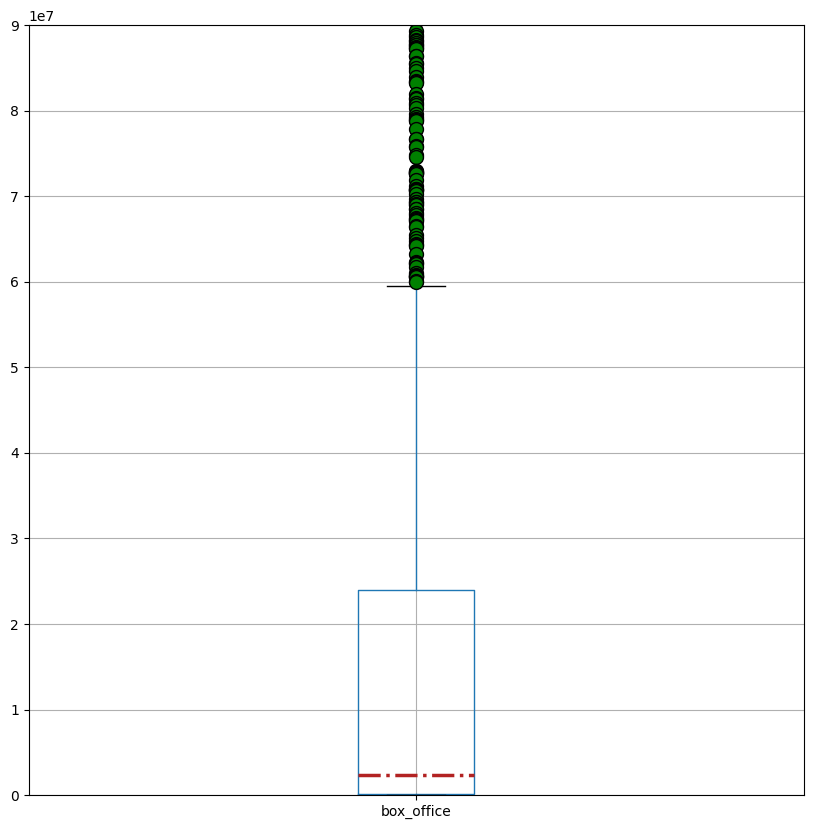

In [96]:
boxplot_data = data.query('box_office!=-1')
display(boxplot_data['box_office'].describe())
get_swipe_range(boxplot_data['box_office']) 
fig,axes = plt.subplots(figsize=(10,10))
flierprops = dict(marker='o', markerfacecolor='green', markersize=10,linestyle='none')
medianprops = dict(linestyle='-.', linewidth=2.5, color='firebrick')
boxplot_data.boxplot('box_office', grid=True, flierprops=flierprops, medianprops=medianprops)
axes.set_ylim(0,90000000)
display(boxplot_data[boxplot_data['box_office']==0].shape[0])

По базе данных из 3134 значений установлено, что среднее значение прибыли от проката равно  77,064 тыс. рублей, медианное значение равно 2,409 тыс.рублей. Такое большое отклонение вызвано спецификой кинобизнеса, когда одни фильмы могут иметь оглушительный кассовый успех. а другие провалиться в прокате. Например, максимальные кассовые сборы имеет лента "Холоп" (чуть более 3 млрд. рублей), а минимальные значения близки к нулю. Это видно также по величине среднеквадратичного отклонения в размере 241,178 тыс.рублей.

#### Колонка ratings 

Вывод уникальных имен:

In [97]:
ratings_unique = data['ratings'].unique()
print(ratings_unique)

['6.8' '7.5' '7.6' '6.5' '6.6' '8.3' '6.7' '6.9' '8.0' '7.9' '7.1' '7.7'
 '5.8' '6.2' '6.1' '7.2' '7.0' 0 '6.3' '7.4' '8.2' '5.9' '6.4' '5.6' '7.3'
 '7.8' '4.4' '5.7' '5.5' '6.0' '4.7' '5.4' '5.2' '5.3' '64%' '4.1' '2.9'
 '5.1' '4.6' '4.8' '4.9' '3.0' '8.5' '3.2' '3.1' '2.1' '3.7' '4.5' '8.1'
 '5.0' '3.9' '4.0' '3.8' '4.2' '4.3' '2.5' '3.4' '2.8' '8.4' '3.5' '1.5'
 '3.3' '8.6' '1.0' '88%' '1.6' '83%' '2.6' '94%' '3.6' '90%' '8.8' '79%'
 '1.4' '89%' '19%' '98%' '9.2' '1.2' '2.7' '1.9' '2.4' '99%' '28%' '8.7'
 '91%' '9.1' '97%' '8.9' '62%' '9.0' '1.7' '1.1' '1.8' '1.3']


Эта колонка содержит значения типов string  и int. Кроме того, некоторые значения указаны в процентах. Чтобы привести все значения в тип float сначала приведу колонку в тип строки, чтобы заменить значения int на string, затем уберу % там, где он есть. Затем приведу всю колонку в тип float и для значений больше 10 проведу деление на 10:

In [98]:
data['ratings'] = data['ratings'].astype('string')
data.loc[data['ratings'].str.contains('%'),['ratings']] = data['ratings'].apply(lambda x:(x[:-1]))
data['ratings'] = data['ratings'].astype('float')
data.loc[data['ratings']>10,['ratings']] = data['ratings']/10
print(data['ratings'].unique())

[6.8 7.5 7.6 6.5 6.6 8.3 6.7 6.9 8.  7.9 7.1 7.7 5.8 6.2 6.1 7.2 7.  0.
 6.3 7.4 8.2 5.9 6.4 5.6 7.3 7.8 4.4 5.7 5.5 6.  4.7 5.4 5.2 5.3 4.1 2.9
 5.1 4.6 4.8 4.9 3.  8.5 3.2 3.1 2.1 3.7 4.5 8.1 5.  3.9 4.  3.8 4.2 4.3
 2.5 3.4 2.8 8.4 3.5 1.5 3.3 8.6 1.  8.8 1.6 2.6 9.4 3.6 9.  1.4 8.9 1.9
 9.8 9.2 1.2 2.7 2.4 9.9 8.7 9.1 9.7 1.7 1.1 1.8 1.3]


Вывод статистики по колонке рейтингов и строительство диаграммы размаха:

count              6,964.0
mean    5.5733486502010345
std     2.4607478208135354
min                    0.0
25%                    5.3
50%                    6.4
75%                    7.1
max                    9.9
Name: ratings, dtype: float64

Границы разброса значений для колонки: ratings
Левое значение: ratings   2.6
Правое значение: ratings   9.8


960

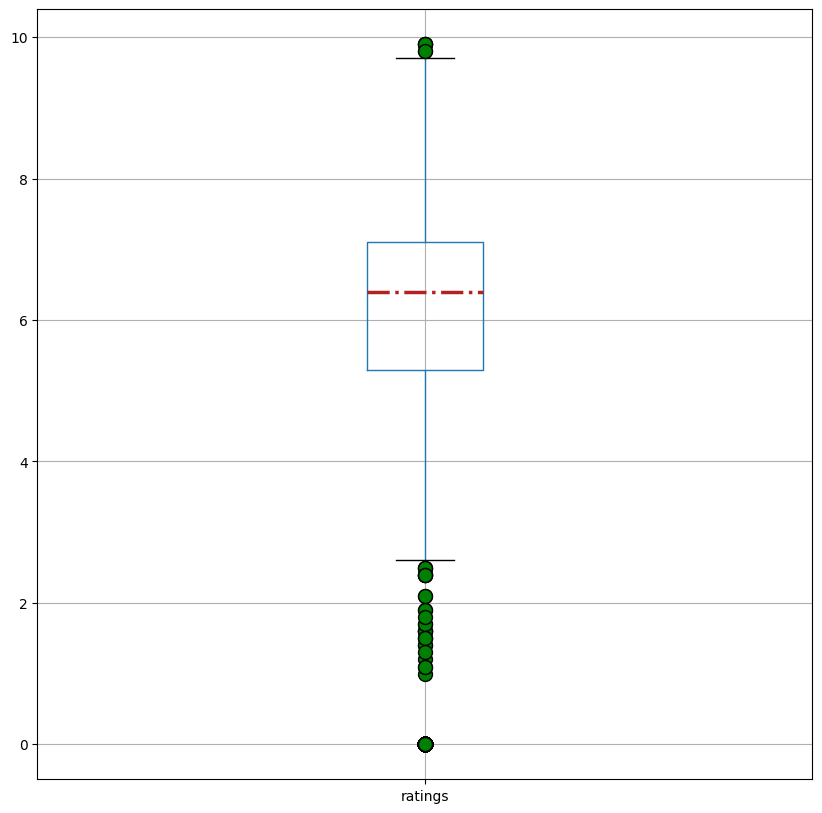

In [99]:
display(data['ratings'].describe())
get_swipe_range(data['ratings']) 
display(data[data['ratings']==0].shape[0])
fig,axes = plt.subplots(figsize=(10,10))
flierprops = dict(marker='o', markerfacecolor='green', markersize=10,linestyle='none')
medianprops = dict(linestyle='-.', linewidth=2.5, color='firebrick')
data.boxplot('ratings', grid=True, flierprops=flierprops, medianprops=medianprops)
plt.show()

Оценка возможности среза датафрейма для исследования по этой колонке:

In [100]:
print(data.query('2.6<=ratings<=9.8').shape[0]/data.shape[0])

0.8574095347501436


Средний рейтинг фильмов в базе данных составляет 5.5, а медианный равен 6.4. У четверти фильмов в базе данных рейтинг больше 7.1. Благоприятный диапазон для избавления от выбросов составляет 2.6-9.8

In [101]:
#Вывод информации о пропусках
missing_values_tab(data)
data.info()

Ваш датафрейм содержит 17 колонок и 6964 строк.

Он имеет  0 колонок с пропущенными значениями.


,Пропущенные значения,% от всех значений,Тип данных


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6964 entries, 7456 to 1080
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   title                  6964 non-null   object             
 1   puNumber               6964 non-null   int64              
 2   show_start_date        6964 non-null   datetime64[ns, UTC]
 3   type                   6964 non-null   object             
 4   film_studio            6964 non-null   object             
 5   production_country     6964 non-null   object             
 6   director               6964 non-null   object             
 7   producer               6964 non-null   object             
 8   age_restriction        6964 non-null   object             
 9   refundable_support     6964 non-null   float64            
 10  nonrefundable_support  6964 non-null   float64            
 11  budget                 6964 non-null   float64       

Сравнение размеров оригинального и обработанного датасетов:

In [102]:
print(6964/7486)

0.930269837029121


Обработанный датасет стал на 7% меньше первоначального. По результатам его осмотра, он кажется готовым к изучению.

### Добавление  новых колонок:
Создайте столбец с информацией о годе проката. Выделите год из даты премьеры фильма;
Создайте два столбца: с именем и фамилией главного режиссёра и основным жанром фильма. В столбцы войдут первые значения из списка режиссёров и жанров соответственно;
Посчитайте, какую долю от общего бюджета фильма составляет государственная поддержка. 

#### Создание колонки с годом проката 

In [103]:
data['show_year'] = data['show_start_date'].dt.year

#### Создание колонки с главным жанром 

In [104]:
def main_genre(genre):    
        #разбиваем строку жанров на слова по запятой и сохраняем в список
        temp = str(genre).split(',')        
        #выбираем первое слово
        new_name = temp[0]
        return new_name    

Применение функции к колонке:

In [105]:
data['main_genre'] = data['genres'].apply(main_genre)
display(data[['genres','main_genre']])

,genres,main_genre
7456,комедия,комедия
5653,"спорт,драма",спорт
6820,"фантастика,боевик,драма",фантастика
6549,"драма,военный,боевик",драма
3488,"фэнтези,боевик,комедия",фэнтези
...,...,...
1797,неизвестно,неизвестно
7009,"драма,криминал,детектив",драма
5074,"драма,военный,биография",драма
5037,"мультфильм,фэнтези,боевик",мультфильм


#### Создание колонки с главным режиссером 

Для создания этой колонки применю ту же функцию, что и в случае с жанрами:

In [106]:
data['main_director'] = data['director'].apply(main_genre)

Проверка:

In [107]:
display(data[['director','main_director']])

,director,main_director
7456,К.Шипенко,К.Шипенко
5653,А.Мегердичев,А.Мегердичев
6820,"Джо Руссо, Энтони Руссо",Джо Руссо
6549,А.Сидоров,А.Сидоров
3488,"Йоаким Реннинг, Эспен Сандберг",Йоаким Реннинг
...,...,...
1797,С.Юзеев,С.Юзеев
7009,П.Левченко,П.Левченко
5074,Мартин Скорсезе,Мартин Скорсезе
5037,Дженнифер Ю,Дженнифер Ю


In [108]:
main_director_unique = data['main_director'].unique()
print_long_lists(main_director_unique)

['К.Шипенко' 'А.Мегердичев' 'Джо Руссо' 'А.Сидоров' 'Йоаким Реннинг'
 'Рич Мур' 'Крис Рено' 'Рубен Флейшер' 'Йоаким Роннинг' 'Тодд Филлипс'
 'Энтони Руссо' 'Крис Бак' 'Дин ДеБлуа' 'И.Куликов' 'Джей Джей Абрамс'
 'Д.Дьяченко' 'Кайл Балда' 'Тим Миллер' 'Дэвид Эйр' 'Дэвид Йейтс'
 'Джосс Уидон' 'Джеймс Ван' 'Джеймс Ганн' 'О.Трофим' 'Ф.Гэри Грей'
 'Н.Лебедев' 'Том МакГрат' 'Дункан Джонс' 'Скотт Дерриксон' 'Джейк Касдан'
 'Дэвид Литч' 'Тайка Вайтити' 'Джон Фавро' 'Колин Треворроу' 'Джон Уоттс'
 'Анна Боден' 'Геннадий Тартаковский' 'Квентин Тарантино' 'Джейк Кэздан'
 'Энди Мускетти' 'Хуан Антонио Байона' 'Алан Тэйлор' 'Ф.Бондарчук'
 'Андрес Мускетти' 'Джон М.Чу' 'Брайан Сингер' 'Сергей Бодров'
 'Алехандро Гонсалес Иньярриту' 'Скотт Моужер' 'Ридли Скотт' 'Пит Доктер'
 'Сэм Тейлор-Джонсон' 'Райан Куглер' 'Тим Бёртон' 'Джастин Курзель'
 'Майк Термайер' 'Гарт Дженнингс' 'Джеймс Мэнголд' 'Майкл Бэй'
 'Алекс Куртцман' 'Джон Тёртлтауб' 'Кеннет Брана' 'Райан Джонсон'
 'Д.Киселев' 'Брэд Берд' 'Тим Джо

### Посчитайте, какую долю от общего бюджета фильма составляет государственная поддержка. 

гос.поддержка = refundable_support + nonrefundable_support  
budget = гос.поддержка + иные источники

In [109]:
temp_df = data.query('refundable_support!=(-1) and  nonrefundable_support!=(-1)')
temp_df['gov_help_%'] =round( (temp_df['refundable_support'] + temp_df['nonrefundable_support'])/temp_df['budget']*100,2)
display(temp_df[['budget','refundable_support','nonrefundable_support','gov_help_%']])
data = data.join(temp_df['gov_help_%'])
display(data[['budget','refundable_support','nonrefundable_support','gov_help_%']])

,budget,refundable_support,nonrefundable_support,gov_help_%
7456,"160,000,000.0","25,000,000.0","35,000,000.0",37.5
5653,"590,192,191.0",0.0,"400,000,000.0",67.77
6549,"563,784,717.0","60,000,000.0","120,000,000.0",31.93
5505,"352,477,575.0","50,000,000.0","50,000,000.0",28.37
5708,"148,585,222.0","25,000,000.0","60,000,000.0",57.21
...,...,...,...,...
3711,"18,706,080.0",0.0,"11,520,000.0",61.58
2800,"41,998,984.0",0.0,"25,000,000.0",59.53
3337,"61,000,000.0",0.0,"10,000,000.0",16.39
7344,"47,734,050.0",0.0,"30,000,000.0",62.85


,budget,refundable_support,nonrefundable_support,gov_help_%
7456,"160,000,000.0","25,000,000.0","35,000,000.0",37.5
5653,"590,192,191.0",0.0,"400,000,000.0",67.77
6820,-1.0,-1.0,-1.0,NaN
6549,"563,784,717.0","60,000,000.0","120,000,000.0",31.93
3488,-1.0,-1.0,-1.0,NaN
...,...,...,...,...
1797,-1.0,-1.0,-1.0,NaN
7009,"60,668,576.0",0.0,"25,000,000.0",41.21
5074,-1.0,-1.0,-1.0,NaN
5037,-1.0,-1.0,-1.0,NaN


In [110]:
#заполнение пропусков значением -1
data['gov_help_%'].fillna(-1,inplace=True)

### Вывод по предобработке данных 

**Вывод.**   
В результате предобработки данных были внесены изменения в тип данных некоторых колонок, исправлены пропущенные значения, проведена работа с явными и неявными дубликатами, а также создано несколько вспомогательных колонок. Пропущенные значения в денежных колонках были исправлены на значение "-1", что позволит в будущем по необходимости включать/выключать этот флаг. В результате скорректированный датасет стал на 7% меньше оригинального.

## Проведите исследовательский анализ данных

Посмотрите, сколько фильмов выходило в прокат каждый год. Обратите внимание, что данные о прокате в кинотеатрах известны не для всех фильмов. Посчитайте, какую долю составляют фильмы с указанной информацией о прокате в кинотеатрах. Проанализируйте, как эта доля менялась по годам. Сделайте вывод о том, какой период полнее всего представлен в данных.
Изучите, как менялась динамика проката по годам. В каком году сумма сборов была минимальной? А максимальной?
С помощью сводной таблицы посчитайте среднюю и медианную сумму сборов для каждого года. Сравните значения и сделайте выводы.

### Создание датасета для работы 

Создание датасета с фильмами с известными сборами, т.е где box_office>=0 а также вспомогательных колонок кассовых сборов в тысячах и миллионах рублей.

In [111]:
#датафрейм с фильмами, для которых известны сборы
filtered_df = data.query('box_office>=0')
#Переведем колонку box_office в тыс. руб
filtered_df['revenue_1000'] = filtered_df['box_office']/1000
#Создание колонки с млн. рублей
filtered_df['revenue_mln'] = filtered_df['box_office']/1000000

### расчет доли фильмов с указанной информацией о сборах

In [112]:
#Создание группировки по годам и кол-ву фильмов
tmp_0 = data.pivot_table(index='show_year',values='box_office',aggfunc='count').reset_index()
#Создание отсортированного списка годов проката
list_of_years = data['show_year'].sort_values().unique()
ratios = []
# Цикл для каждого года вычисляет отношение известных фильмов к общему количеству фильмов за тот год
# и помещает округленные значения в процентах в список
for year in list_of_years:    
        ratios.append( round(data[(data['show_year']==year)
               & (data['box_office']!=(-1))].shape[0]/data[data['show_year']==year].shape[0]*100,2))
# Создание Series из списка
ratio_series = pd.Series(ratios,name='% известных')
#Приклеивание series к датафрейму справа
tmp_0 = pd.concat([tmp_0,ratio_series],axis=1)
tmp_0 = tmp_0.rename(columns={'show_year':'Год проката','box_office':'Количество фильмов'})
display(tmp_0)

,Год проката,Количество фильмов,% известных
0,2010,801,13.11
1,2011,532,20.49
2,2012,536,23.88
3,2013,603,30.51
4,2014,755,36.95
5,2015,679,68.48
6,2016,750,70.13
7,2017,498,71.69
8,2018,886,53.61
9,2019,924,57.36


Как видно из таблицы процент фильмов с известными кассовыми сборами растет из года в год. Падение значений в 2018 и 2019 годах можно объяснить эпидемией ковид-19, когда были закрыты кинотеатры для показа.

### Построение диаграммы количества фильмов по годам  

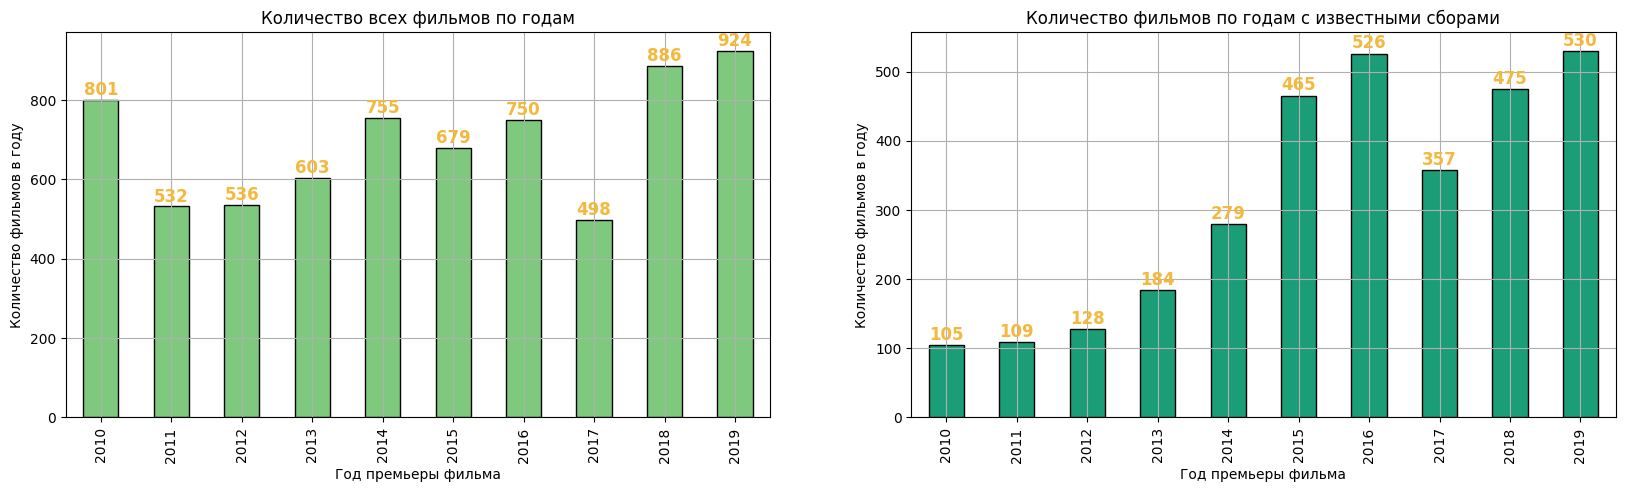

In [113]:
fig,axes = plt.subplots(1,2,figsize=(20,5),sharey=False)
# Диаграмма всех фильмов
data.groupby('show_year')['title'].count().plot.bar(ax=axes[0], edgecolor='black',grid=True,colormap='Accent')
#Диаграмма  фильмов с известными сборами
filtered_df.groupby('show_year')['title'].count().plot.bar(ax=axes[1], edgecolor='black',grid=True, colormap='Dark2')
axes[0].set_title('Количество всех фильмов по годам')
axes[0].set_xlabel("Год премьеры фильма")
axes[0].set_ylabel("Количество фильмов в году")
axes[1].set_title('Количество фильмов по годам c известными сборами')
axes[1].set_xlabel("Год премьеры фильма")
axes[1].set_ylabel("Количество фильмов в году")
#Нанесение надписей
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
for index in range(len(axes)):
    rects = axes[index].patches
    for rect in rects:    
            height = rect.get_height()    
            axes[index].text(rect.get_x() + rect.get_width() / 2, height + 2, round(height,1),
            ha="center", va="bottom",weight='bold',size='large',c=color[0])
plt.show()
#print(axes)


По прошествии десяти лет, количество фильмов в базе данных увеличился всего на 123 единицы. Но количество фильмов с известными сборами увеличилось в 5 раз, а их доля в общем количестве фильмов увеличилась с 13% до 57%, т.е более чем в 4 раза.

### Построение диаграммы средних сборов по годам 

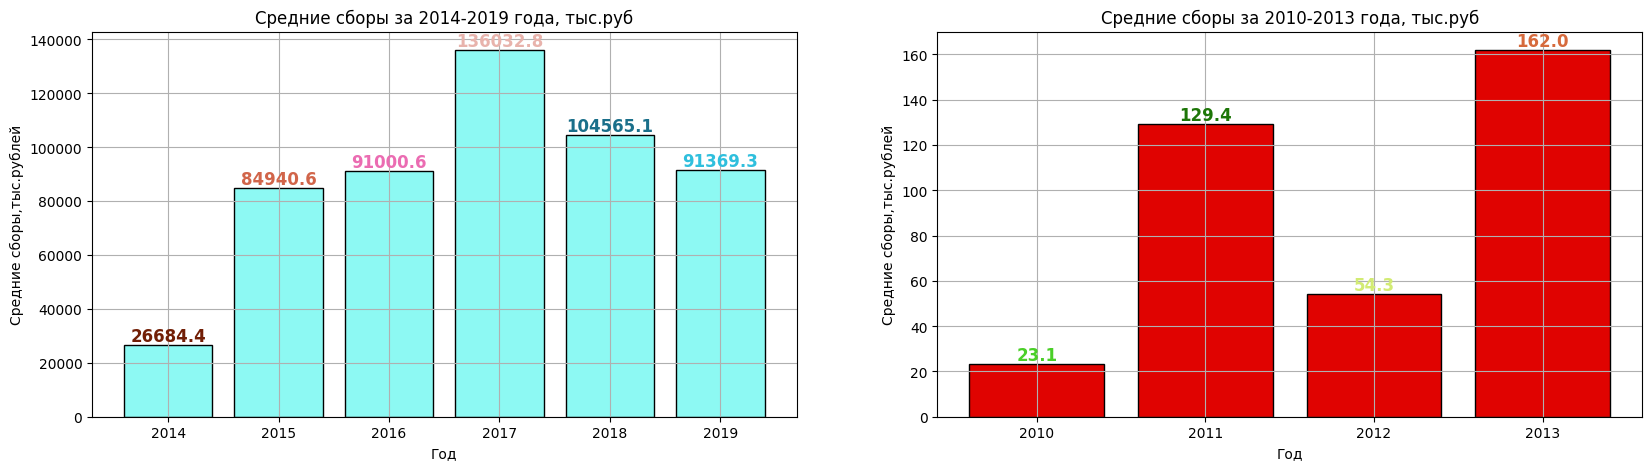

In [114]:
a = filtered_df.query('2014<=show_year<=2019').pivot_table(index='show_year',values='revenue_1000')
a1 = filtered_df.query('2010<=show_year<=2013').pivot_table(index='show_year',values='revenue_1000')
a1_xlabels = [2010,2011,2012,2013]
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1, 2, 1) 
ax2 = fig.add_subplot(1, 2, 2)
#Постороение столбиковой диаграммы ср. сборов за 2014-2019
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
ax1.bar(x= a.index.values,height = a['revenue_1000'],color=color,ec='black')
#Постороение столбиковой диаграммы ср. сборов за 2010-2013
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
ax2.bar(a1_xlabels, a1['revenue_1000'],color=color,ec='black',tick_label=a1_xlabels)
#Сеточка
ax1.grid(); ax2.grid()
#Оформление
ax2.set_title('Средние сборы за 2010-2013 года, тыс.руб') 
ax2.set_xlabel('Год') 
ax2.set_ylabel('Средние сборы,тыс.рублей')
ax1.set_title('Средние сборы за 2014-2019 года, тыс.руб') 
ax1.set_xlabel('Год') 
ax1.set_ylabel('Средние сборы,тыс.рублей')
# Нанесение значений
rects=ax1.patches
rects2=ax2.patches
for rect in rects:
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
    height = rect.get_height()    
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 2, round(height,1),
        ha="center", va="bottom",weight='bold',size='large',c=color[0])
for rect in rects2:
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
    height = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width() / 2, height, round(height,1),
        ha="center", va="bottom",weight='bold',size='large',c=color[0])
plt.show()

Наполняемость базы открытыми данными о сборах позволило уточнить динамику и величины средних и медианных сборов фильмов по годам.

### Построние диаграммы медианных сборов по годам 

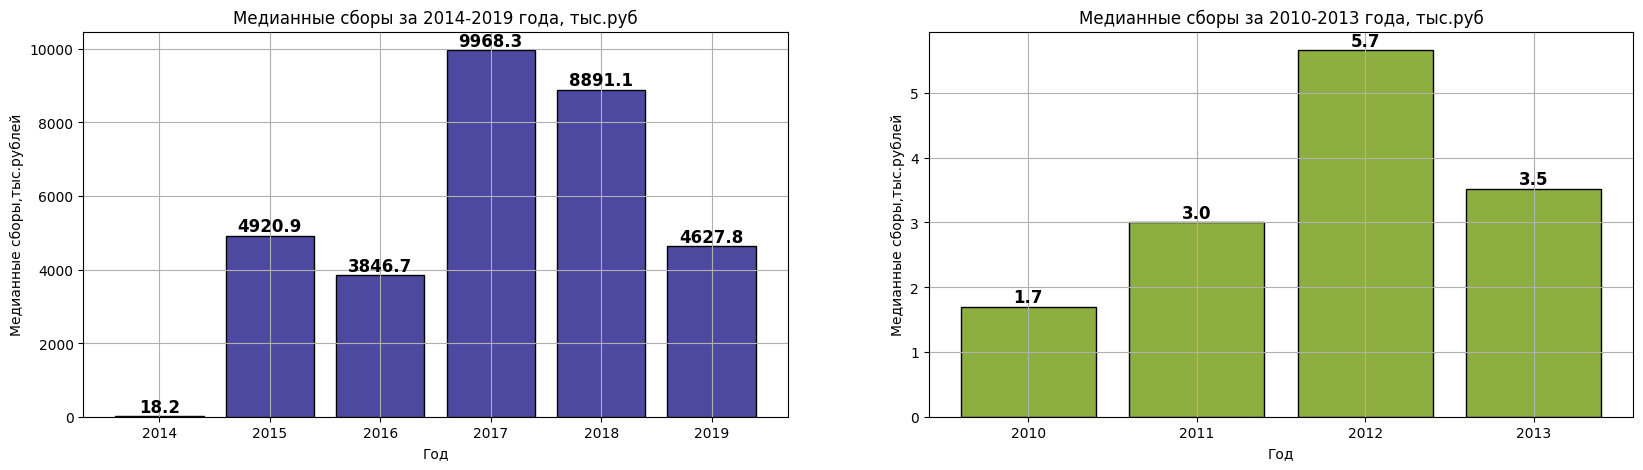

In [115]:
#Данные для диаграмм
a = filtered_df.query('2014<=show_year<=21019').pivot_table(index='show_year',values='revenue_1000',aggfunc='median')
a1 = filtered_df.query('2010<=show_year<=2013').pivot_table(index='show_year',values='revenue_1000',aggfunc='median')
a1_xlabels = [2010,2011,2012,2013]

fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1, 2, 1) 
ax2 = fig.add_subplot(1, 2, 2)
#Построение столбиковой диаграммы ср. сборов за 2014-2019
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
ax1.bar(x= a.index.values,height = a['revenue_1000'],color=color,ec='black')
#Построение столбиковой диаграммы ср. сборов за 2010-2013
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
ax2.bar(a1_xlabels, a1['revenue_1000'],color=color,ec='black',tick_label=a1_xlabels)
#Сеточка
ax1.grid(); ax2.grid()
#Оформление
ax2.set_title('Медианные сборы за 2010-2013 года, тыс.руб') 
ax2.set_xlabel('Год') 
ax2.set_ylabel('Медианные сборы,тыс.рублей')
ax1.set_title('Медианные сборы за 2014-2019 года, тыс.руб') 
ax1.set_xlabel('Год') 
ax1.set_ylabel('Медианные сборы,тыс.рублей')
# Нанесение значений
rects=ax1.patches
rects2=ax2.patches
for rect in rects:    
    height = rect.get_height()    
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 2, round(height,1),
        ha="center", va="bottom",weight='bold',size='large')
for rect in rects2:   
    height = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width() / 2, height, round(height,1),
        ha="center", va="bottom",weight='bold',size='large')
plt.show()

Построение сводной таблицы медианных и средних кассовых сборов:

In [116]:
df = filtered_df.pivot_table(index='show_year',values='revenue_1000',aggfunc=['median','mean']).round(2)
df = df.droplevel(level=1,axis=1)
df ['div']  = round(df['mean']/df['median'],1)
df = df.rename(columns={'mean':'Средние кассовые сборы,тр','median':'Медианные кассовые сборы,тр'})
df.index.name = 'Год проката'
display(df)
display(filtered_df[filtered_df['show_year'] == 2013].sort_values('box_office',ascending=False)[['title','box_office']].head())
display(filtered_df[filtered_df['show_year'] == 2014].sort_values('box_office',ascending=False)[['title','box_office']].head())
display(filtered_df[(filtered_df['show_year'] == 2014) & (filtered_df['box_office']>10000000)]['title'].count())

,"Медианные кассовые сборы,тр","Средние кассовые сборы,тр",div
Год проката,,,
2010,1.7,23.13,13.6
2011,3.0,129.38,43.1
2012,5.66,54.34,9.6
2013,3.52,161.95,46.0
2014,18.16,"26,684.42","1,469.4"
2015,"4,920.93","84,940.57",17.3
2016,"3,846.68","91,000.57",23.7
2017,"9,968.34","136,032.79",13.6
2018,"8,891.1","104,565.06",11.8


,title,box_office
1498,Невидимки,"19,957,031.5"
1256,Великая красота,"4,321,638.0"
1743,Иван Царевич и Серый Волк 2,"1,081,797.0"
791,Что творят мужчины,"779,027.6"
1281,Пока еще жива,"365,353.6"


,title,box_office
1982,Седьмой сын,"1,016,410,635.3"
2383,Исход: Цари и боги,"970,276,839.8"
2410,Пятьдесят оттенков серого /По произведению Э.Л...,"963,728,813.5"
2406,Kingsman: Секретная служба,"566,924,625.9"
2384,Ночь в музее: Секрет гробницы,"488,223,744.1"


33

В результате сравнения медианных и средних показателей кассовых сборов по годам видно, что аномальным является 2014 год, где среднее больше медианного в 1469 раз, что может говорить о том, что в том году вышло много фильмов, которые собрали хорошую кассу(из 279 фильмов 33 собрали больша 100 млн) и было много фильмов с низкими сборами.

### Построение диаграммы самых кассовых фильмов

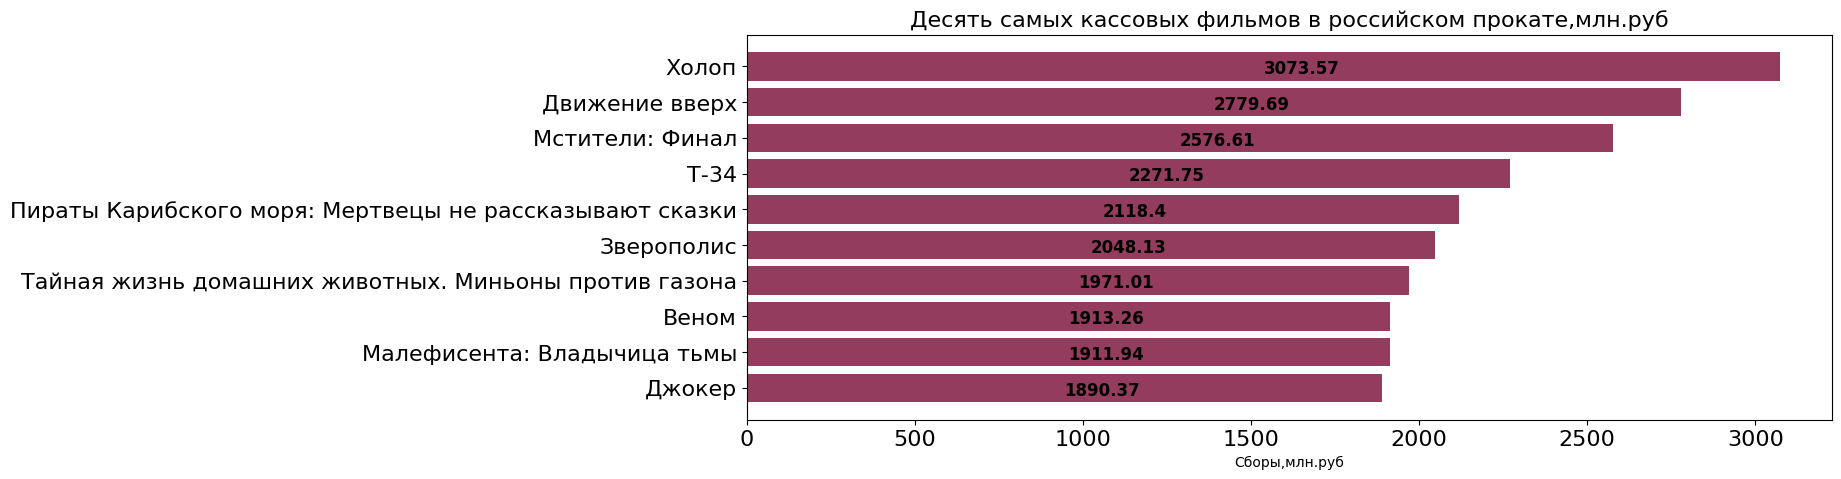

In [117]:
barh_data =  filtered_df.groupby('title')['revenue_mln'].sum().sort_values().tail(10)
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot()
ax.barh( barh_data.index.values, barh_data,color=color[0])
#Оформление
ax.set_title('Десять самых кассовых фильмов в российском прокате,млн.руб',size=16) 
ax.set_xlabel('Сборы,млн.руб')
#ax.yaxis.set_tick_params(labelsize=20)
ax.tick_params(axis='both',labelsize=16)
#Надписи
rects = ax.patches
for bar in rects:    
    width = bar.get_width()    
    ax.text(width/2, bar.get_y()+0.2, str(round(width, 2)),fontsize='12', weight='bold', color='black') 
plt.show()

### Построение диаграммы кассовых сборов по годам 

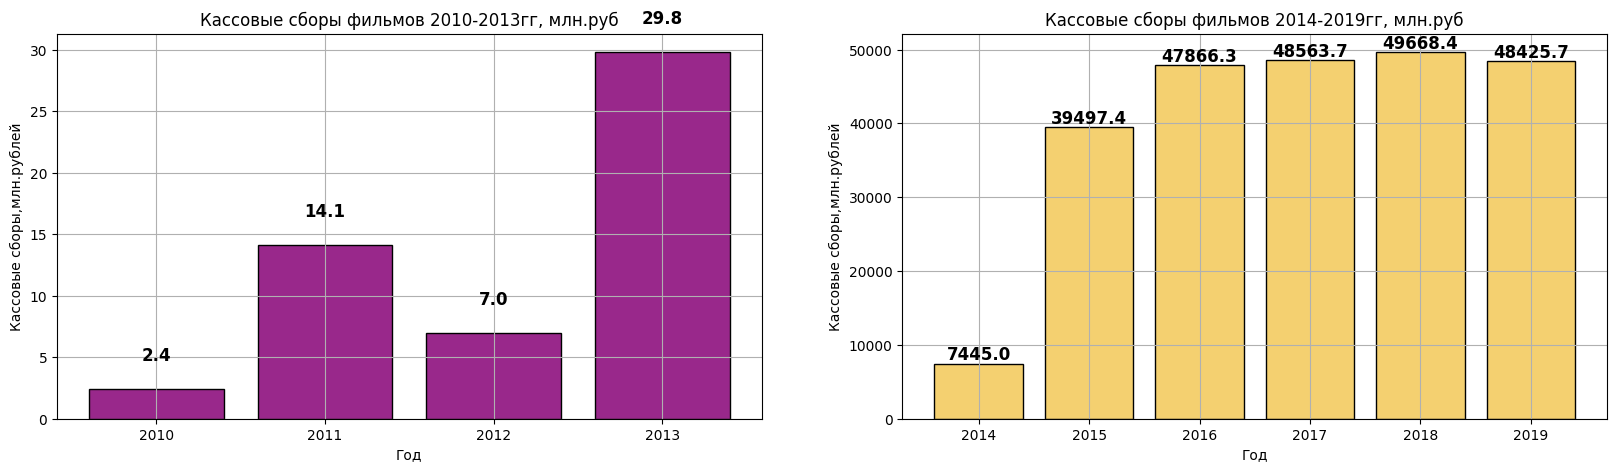

In [118]:
#Данные для диаграмм
a = filtered_df.query('2010<=show_year<=2013').groupby('show_year')['revenue_mln'].sum()
a1 = filtered_df.query('2014<=show_year<=2019').groupby('show_year')['revenue_mln'].sum()
a_xlabels = [2010,2011,2012,2013]

fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1, 2, 1) 
ax2 = fig.add_subplot(1, 2, 2)
#Построение столбиковой диаграммы ср. сборов за 2014-2019
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
ax1.bar(x= a.index.values,height = a,color=color,ec='black',tick_label=a_xlabels)
#Построение столбиковой диаграммы ср. сборов за 2010-2013
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
ax2.bar(a1.index.values, a1,color=color,ec='black')
#Сеточка
ax1.grid(); ax2.grid()
#Оформление
ax2.set_title('Кассовые сборы фильмов 2014-2019гг, млн.руб')  
ax2.set_xlabel('Год') 
ax2.set_ylabel('Кассовые сборы,млн.рублей')
ax1.set_title('Кассовые сборы фильмов 2010-2013гг, млн.руб') 
ax1.set_xlabel('Год') 
ax1.set_ylabel('Кассовые сборы,млн.рублей')
# Нанесение значений
rects=ax1.patches
rects2=ax2.patches
for rect in rects:    
    height = rect.get_height()    
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 2, round(height,1),
        ha="center", va="bottom",weight='bold',size='large')
for rect in rects2:   
    height = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width() / 2, height, round(height,1),
        ha="center", va="bottom",weight='bold',size='large')
plt.show()

Из диаграммы выше видно, что минимальные сборы были в 2010 году - всего 2.4 млн рублей, а максимальные сборы были в 2018 году и составили примерно 49,7 млрд рублей.

### Влияние возраста аудитории

Вывод статистики:

In [119]:
tmp_data = filtered_df.query('2015<=show_year<=2019').pivot_table(
    index='age_restriction',values='revenue_1000',aggfunc ='mean')
display(tmp_data.describe().round(2))

,revenue_1000
count,5.0
mean,"101,004.57"
std,"74,104.99"
min,"8,890.96"
25%,"51,464.16"
50%,"94,453.09"
75%,"174,193.81"
max,"176,020.85"


### Построение диаграммы медианных и средних сборов по зрительским категориям за 2015-2019 годы.

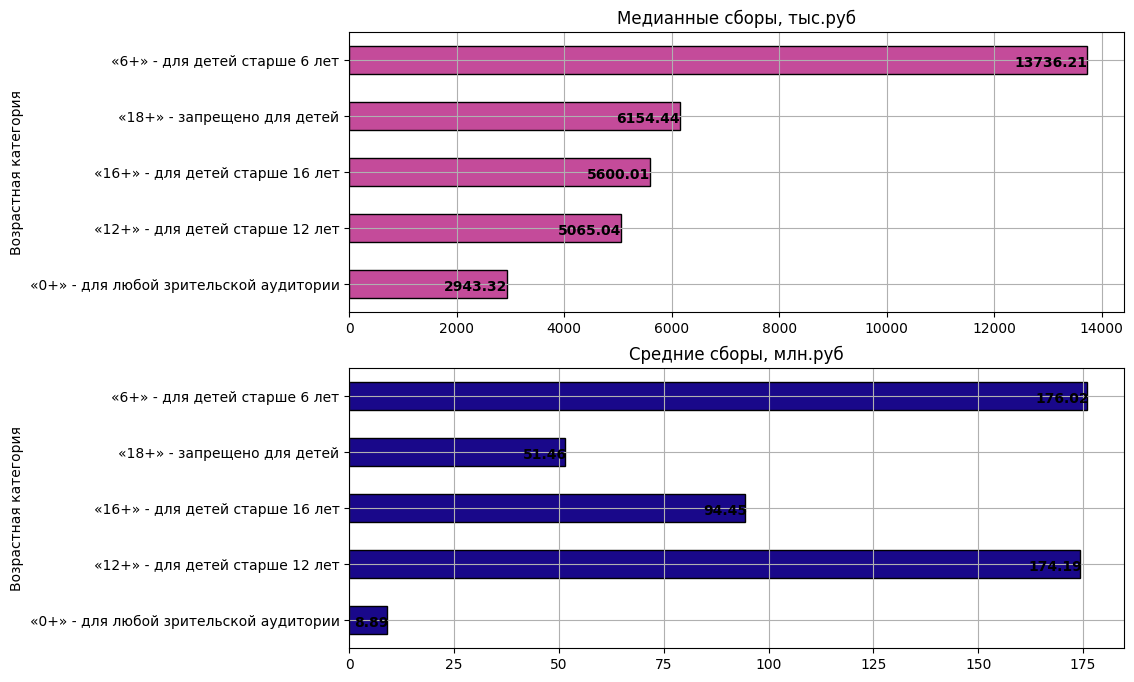

In [120]:
fig,axes = plt.subplots(2,1,figsize=(10,8))
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
# Диаграмма медианных сборов
age_median_revenue = filtered_df.query('2015<=show_year<=2019').pivot_table(
    index='age_restriction',values='revenue_1000',aggfunc ='median').plot(
    kind='barh',ax=axes[0],edgecolor='black',grid=True,color = color,  
    title = 'Медианные сборы, тыс.руб', xlabel = 'Возрастная категория',legend=False)
# Диаграмма средних сборов
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
age_mean_revenue = filtered_df.query('2015<=show_year<=2019').pivot_table(
    index='age_restriction',values='revenue_mln',aggfunc ='mean').plot(
    kind='barh',ax=axes[1],edgecolor='black',grid=True,color = color,
    title = 'Средние сборы, млн.руб',  xlabel = 'Возрастная категория',legend=False)
plt.subplots_adjust(hspace=0.2)   # регулирование промежутка между графиками
# Надписи на первом графике
rects = axes[0].patches
for bar in rects:    
    width = bar.get_width()    
    axes[0].text(width+0.5, bar.get_y()+0.2, str(round(width, 2)),
                 fontsize='medium', weight='bold', color='black',ha='right',va='center') 
#Надписи на втором графике
rects = axes[1].patches
for bar in rects:    
    width = bar.get_width()    
    axes[1].text(width+0.5, bar.get_y()+0.2, str(round(width, 2)),
                 fontsize='medium', weight='bold', color='black',ha='right',va='center') 
plt.show()            

Из диаграммы видно, что фильмы 6+ и 12+ пользуются большой популярностью. В обоих случаях видно, что медианные сборы сильно уступают средним сборам, что говорит о том, что в каждой категории есть фильмы, которые имели оглушительный кассовый успех.

### Построение диграммы количества выпущенных фильмов по категориям зрителей.

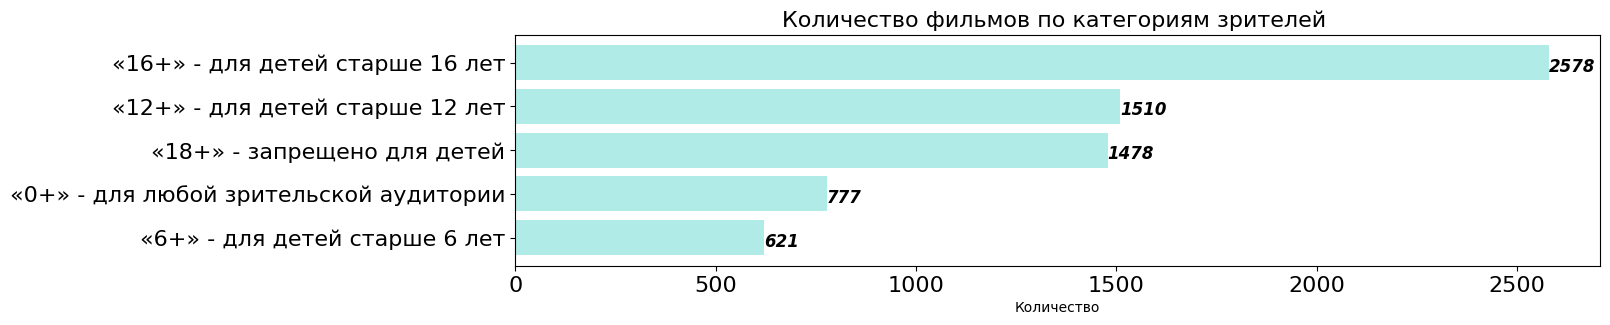

In [121]:
barh_data_1 = data.groupby('age_restriction')['box_office'].count().sort_values()
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
fig = plt.figure(figsize=(14,3))
ax = fig.add_subplot()
ax.barh( barh_data_1.index.values, barh_data_1,color=color[0])
#Оформление
ax.set_title('Количество фильмов по категориям зрителей ',size=16) 
ax.set_xlabel('Количество')
#ax.yaxis.set_tick_params(labelsize=20)
ax.tick_params(axis='both',labelsize=16)
#Надписи
rects = ax.patches
for bar in rects:    
    width = bar.get_width()    
    ax.text(width, bar.get_y()+0.2, str(round(width, 2)),fontsize='large', style='oblique',
            weight='bold', color='k',ha='left') 
plt.show()

### Построение диаграммы кассовых сборов по категориям за 2010-2019 годы

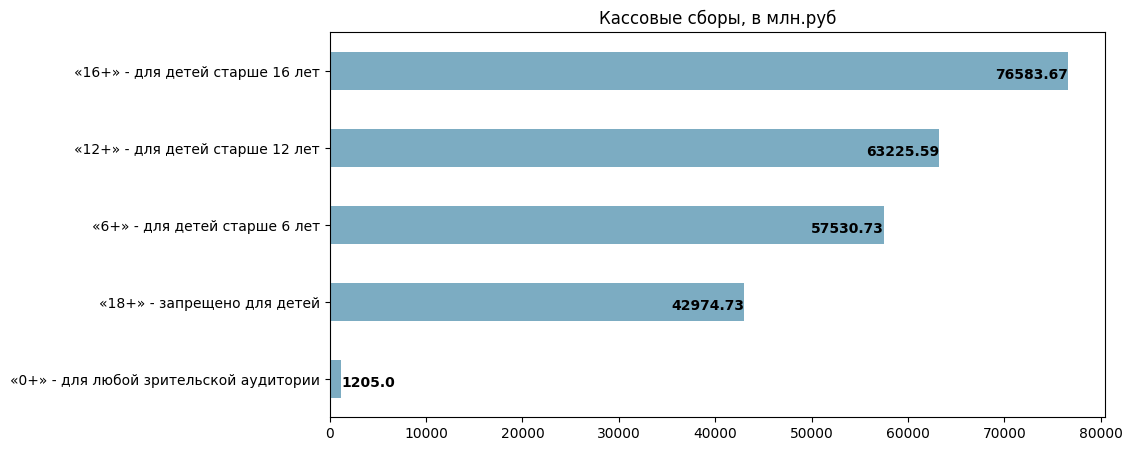

In [122]:
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) ]
fig,axes = plt.subplots(figsize=(10,5))
bar = filtered_df.groupby('age_restriction')['revenue_mln'].sum().sort_values().plot(
    kind = 'barh', ylabel = 'Сборы', xlabel='', color = color, title = 'Кассовые сборы, в млн.руб')
rects = axes.patches
for index in range(len(rects)):    
    if index==0:
        width = rects[index].get_width()
        axes.text(width+0.5, rects[index].get_y()+0.2, str(round(width, 2)),
                 fontsize='medium', weight='bold', color='black',va='center')
    else:
            width = rects[index].get_width()    
            axes.text(width+0.5, rects[index].get_y()+0.2, str(round(width, 2)),
                 fontsize='medium', weight='bold', color='black',va='center',ha='right')    
plt.show()

Из трех вышестоящих графиков видно, что, хотя средние сборы фильмов 16+ значительно уступают средним сборам фильмов 6+ и 12+, за счет того, их количество значительно больше, они лидируют по кассовым сборам. Также можно сделать вывод, что зрительская категория  влияет на кассовые сборы фильмов. Фильмы, ориентированные на детскую и подростковую аудиторию приносят значительно больше кассовых сборов. Особенно можно выделить фильмы для категории 6+, которые обладают, если так можно выразиться, отличным КПД.

In [123]:
#Вывод информации о самом кассовом фильме в каждой категории
tmp  = pd.DataFrame()
for category in age_unique:
    row = filtered_df[
        filtered_df['age_restriction']==category].sort_values(
        'box_office',ascending=False).head(1)[
        ['age_restriction','title','show_year','production_country','box_office','budget','refundable_support','nonrefundable_support']]
    tmp = pd.concat([tmp,row])
display(tmp.sort_values('box_office',ascending=False))
print('\n','-'*45,'Фильмы с участием государства','-'*45)
#Вывод информации о самом кассовом фильме в каждой категории для с участием государства
tmp  = pd.DataFrame()
for category in age_unique:
    row = filtered_df[
        (filtered_df['age_restriction']==category) 
    & (filtered_df['refundable_support']!=(-1))].sort_values(
        'box_office',ascending=False).head(1)[
        ['age_restriction','title','show_year','production_country','box_office','budget','refundable_support','nonrefundable_support']]
    tmp = pd.concat([tmp,row])
display(tmp.sort_values('box_office',ascending=False))
    

,age_restriction,title,show_year,production_country,box_office,budget,refundable_support,nonrefundable_support
7456,«12+» - для детей старше 12 лет,Холоп,2019,Россия,"3,073,568,690.79","160,000,000.0","25,000,000.0","35,000,000.0"
5653,«6+» - для детей старше 6 лет,Движение вверх,2017,Россия,"2,779,686,144.0","590,192,191.0",0.0,"400,000,000.0"
6820,«16+» - для детей старше 16 лет,Мстители: Финал,2019,США,"2,576,613,776.83",-1.0,-1.0,-1.0
7258,«18+» - запрещено для детей,Джокер,2019,США - Канада,"1,890,368,076.47",-1.0,-1.0,-1.0
2005,«0+» - для любой зрительской аудитории,Снежная Королева 2: Перезаморозка,2014,Россия,"313,489,846.5","252,489,571.0","30,000,000.0","40,000,000.0"



 --------------------------------------------- Фильмы с участием государства ---------------------------------------------


,age_restriction,title,show_year,production_country,box_office,budget,refundable_support,nonrefundable_support
7456,«12+» - для детей старше 12 лет,Холоп,2019,Россия,"3,073,568,690.79","160,000,000.0","25,000,000.0","35,000,000.0"
5653,«6+» - для детей старше 6 лет,Движение вверх,2017,Россия,"2,779,686,144.0","590,192,191.0",0.0,"400,000,000.0"
2701,«16+» - для детей старше 16 лет,Самый Лучший День,2015,Россия,"683,029,061.4","130,619,336.0","29,000,000.0","34,000,000.0"
2005,«0+» - для любой зрительской аудитории,Снежная Королева 2: Перезаморозка,2014,Россия,"313,489,846.5","252,489,571.0","30,000,000.0","40,000,000.0"
5449,«18+» - запрещено для детей,Про любовь. Только для взрослых,2017,Россия,"113,925,353.0","83,553,412.0",0.0,"30,000,000.0"


In [124]:
# Функция для укорачивания имени категории
def new_age (row):
    if '-' in row:  
        temp = row.split('-')        
    return temp[0]       
            
filtered_df['age_group'] = filtered_df['age_restriction'].apply(new_age)
display(filtered_df[['age_restriction','age_group']])

,age_restriction,age_group
7456,«12+» - для детей старше 12 лет,«12+»
5653,«6+» - для детей старше 6 лет,«6+»
6820,«16+» - для детей старше 16 лет,«16+»
6549,«12+» - для детей старше 12 лет,«12+»
3488,«16+» - для детей старше 16 лет,«16+»
...,...,...
3994,«16+» - для детей старше 16 лет,«16+»
976,«12+» - для детей старше 12 лет,«12+»
2442,«0+» - для любой зрительской аудитории,«0+»
2037,«12+» - для детей старше 12 лет,«12+»


### Построение диаграммы медианных сборов для каждой зрительской категории по годам.

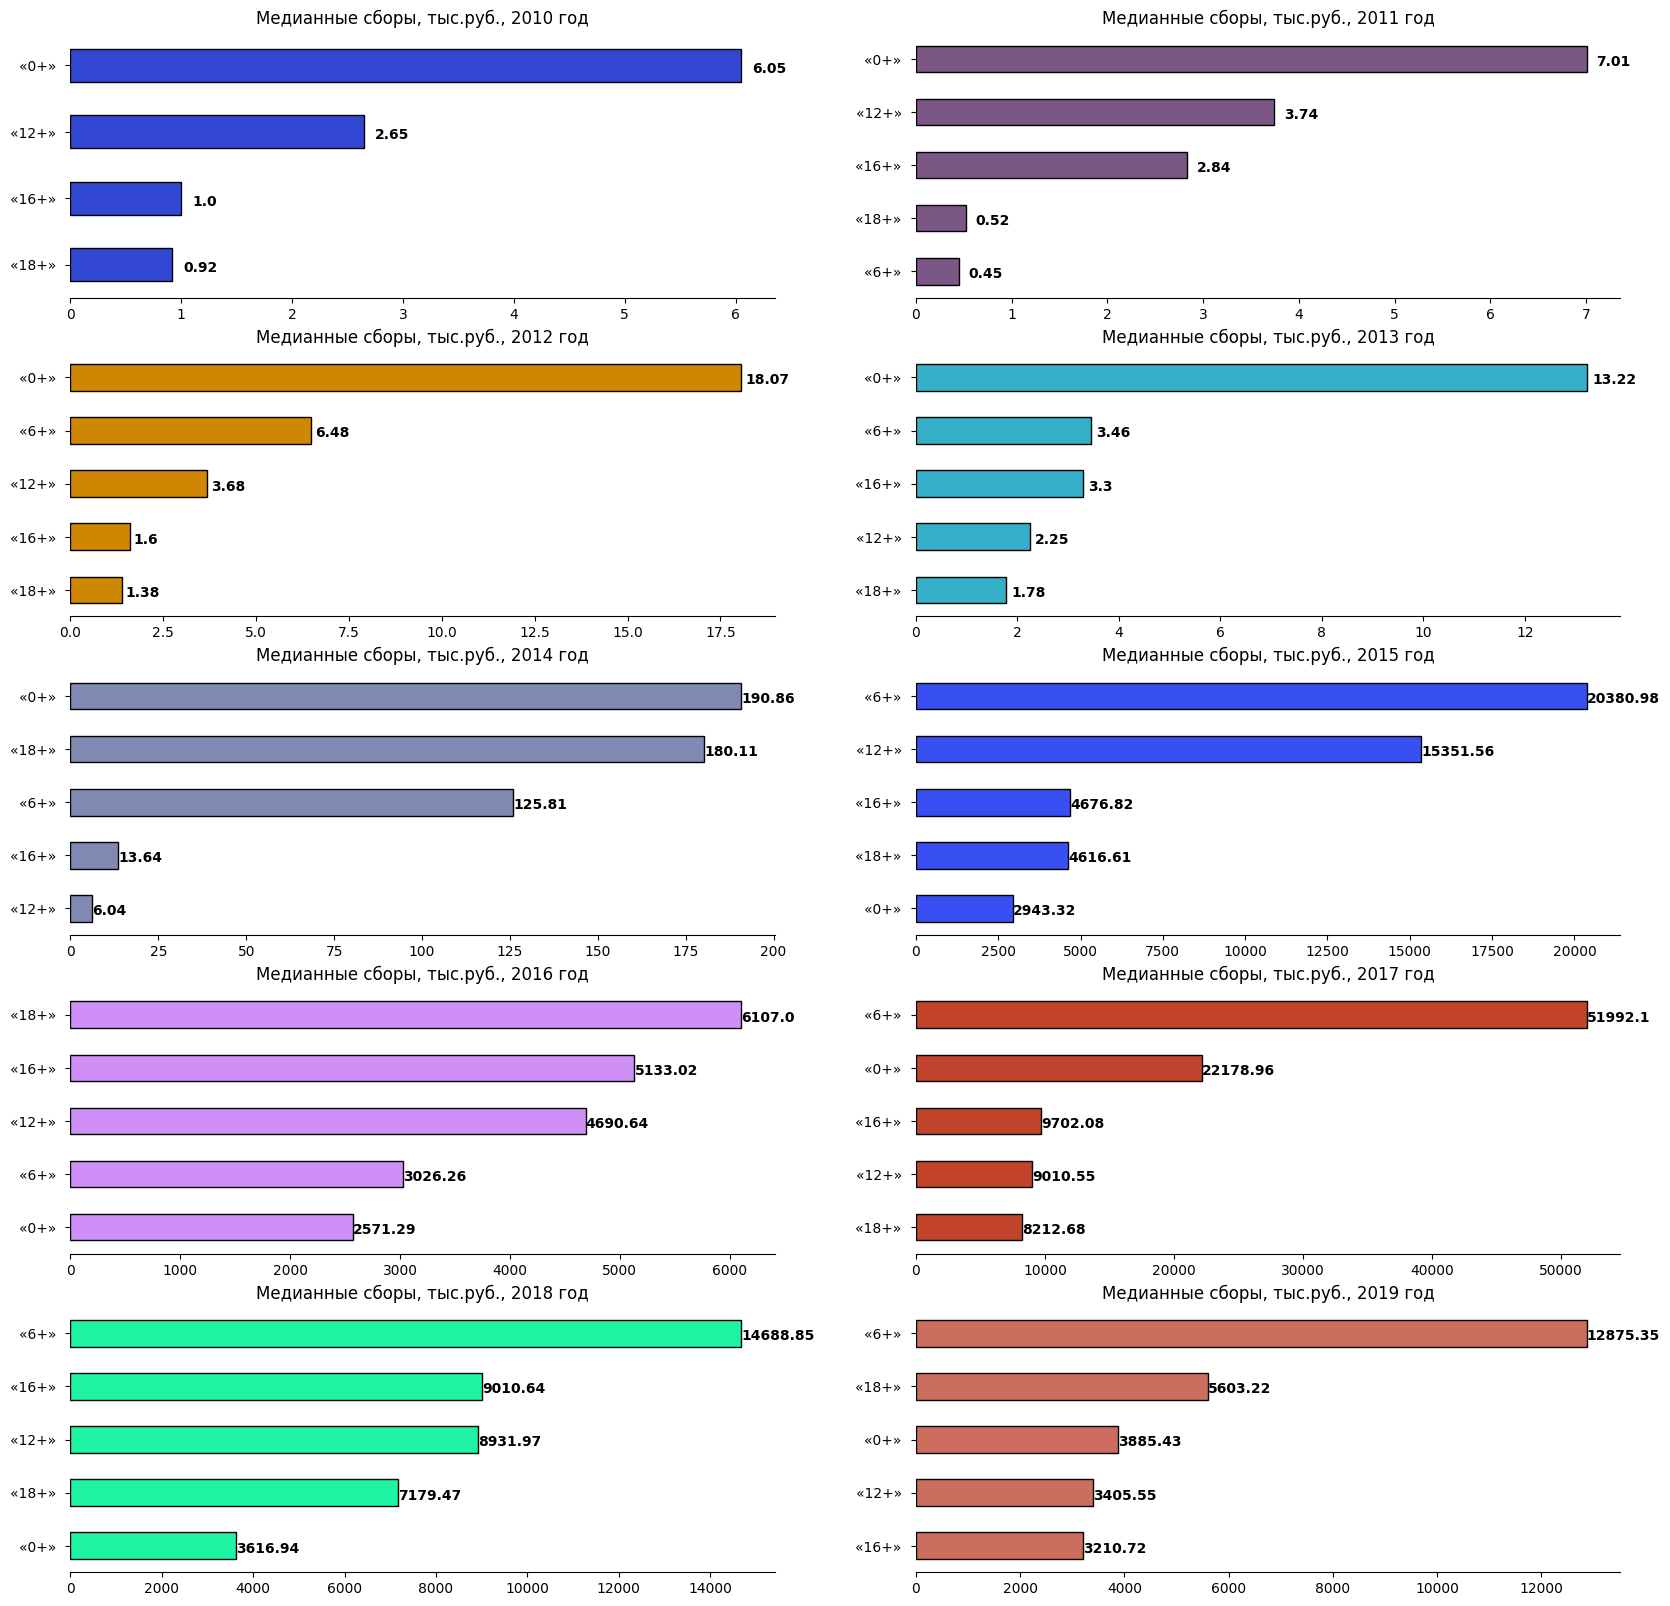

In [125]:
# Лист годов
years = filtered_df['show_year'].sort_values().unique()
cols = 2 # число колонок под вложенные графики
rows = 5 # число строчек под вложенные графики
count = 0
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,20))
for r in range(rows):
    for c in range(cols):            
            color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
            ax = filtered_df[filtered_df['show_year']==years[count]].pivot_table(
                index='age_group',values='revenue_1000', aggfunc ='median').sort_values('revenue_1000').plot(
                kind='barh',ax=axes[r,c], edgecolor='black',  color = color, grid=False,
                title = f'Медианные сборы, тыс.руб., {years[count]} год', xlabel = '',legend=False)
            #Убирание рамок вложенных графиков
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)  
            #Нанесение значений
            rects = axes[r,c].patches                     
            for index in range(len(rects)):
                width = rects[index].get_width()
                t = axes[r,c].text(width+0.1, rects[index].get_y()+0.2, str(round(width, 2)),
                          fontsize='medium', weight='bold', color='black',va='center',ha='left')
            count+=1
plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.show()

Из серии графиков видно, что фильмы для всех зрителей 0+ до 2014 года включительно лидировали по медианным сборам, но затем наступил перелом и фильмы, которые имеют более четкую ориентированность на зрительские сегменты, заняли первые места.

### Построение диаграммы средних сборов для каждой зрительской категории по годам.

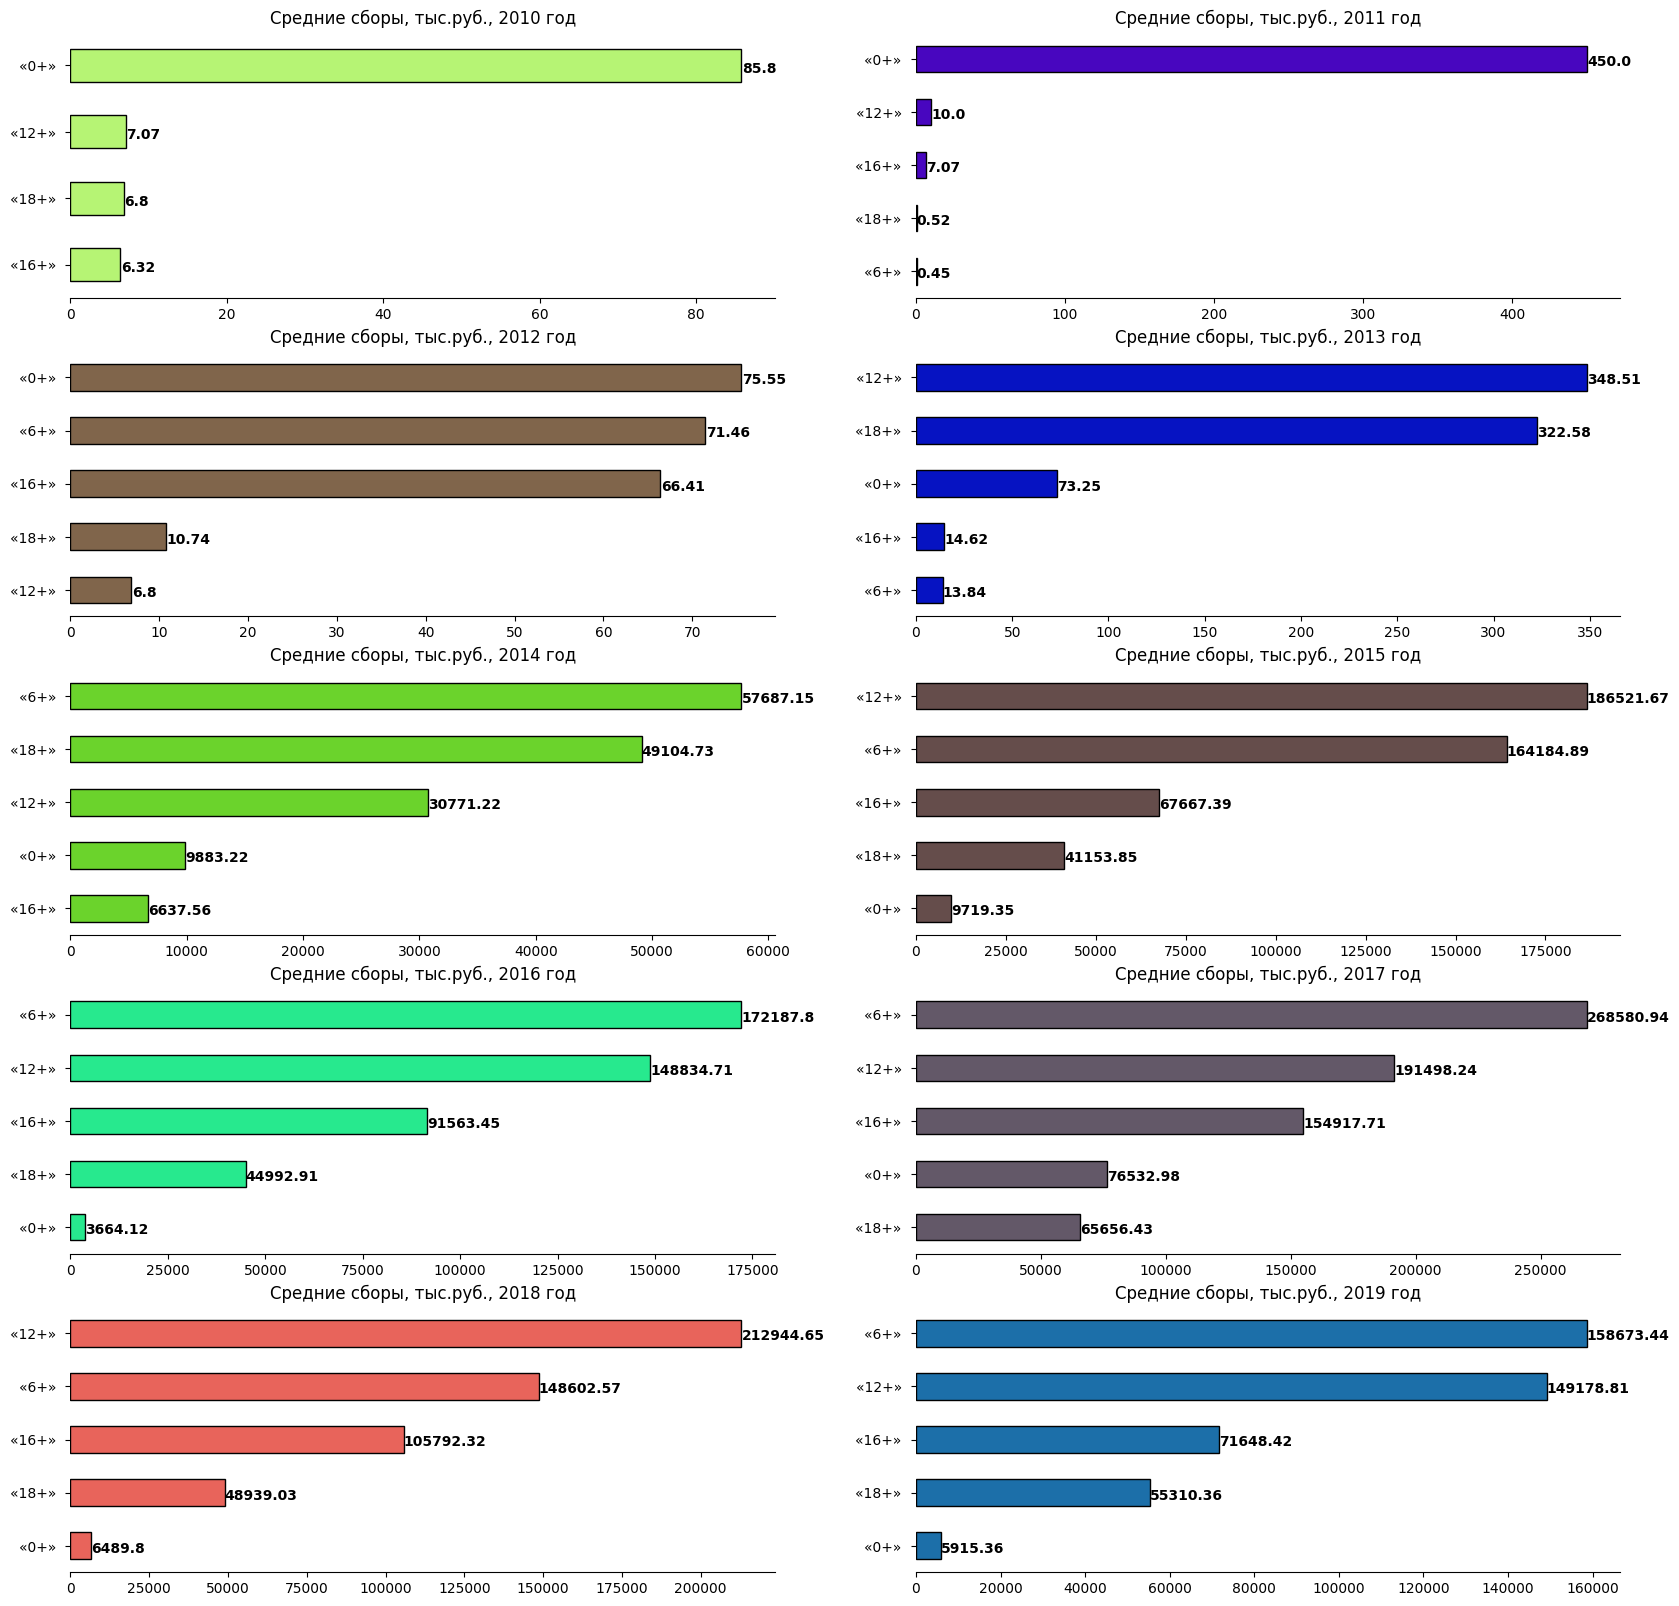

In [126]:
years = filtered_df['show_year'].sort_values().unique()
cols = 2
rows = 5
count = 0
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,20))
#Построение графиков, отсортированных по возрастанию
for r in range(rows):
    for c in range(cols):            
            color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
            ax = filtered_df[filtered_df['show_year']==years[count]].pivot_table(
                index='age_group',values='revenue_1000', aggfunc ='mean').sort_values('revenue_1000').plot(
                kind='barh',ax=axes[r,c], edgecolor='black',  color = color, grid=False,
                title = f'Средние сборы, тыс.руб., {years[count]} год', xlabel = '',legend=False)
            #Убирание рамок вложенных графиков           
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            #Нанесение надписей
            rects = axes[r,c].patches
            for index in range(len(rects)):
                width = rects[index].get_width()
                t = axes[r,c].text(width+0.1, rects[index].get_y()+0.2, str(round(width, 2)),
                          fontsize='medium', weight='bold', color='black',va='center',ha='left')
            count+=1
plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.show()

Если оценивать фильмы по средним сборам, то перелом случился еще раньше - в 2013 году и фильмы для детей и подростков прочно заняли первое и второе место. Здесь эффект сегментации аудитории выражен гораздо сильнее и видно, что фильмы с широким охватом не пользуются популярностью.

### Вывод по разделу 2. 


В результате проведения исследовательского анализа данных мною было подсчитано количество фильмов, выпущенных в российском прокате по каждому году и зрительской категории, оценена динамика их проката. Были определены суммы кассовых сборов фильмов, их средние медианные значения по каждому году, а также по каждой зрительской категории. Также были выявлены лучшие фильмы по кассовым сборам.

## Исследуйте фильмы, которые получили государственную поддержку

### Cоздание датасета и колонок для работы:

In [127]:
data2 = data.query('budget!=(-1) and box_office>=0')
#Содание колонки с тыс. рублей
data2['revenue_1000'] = data2['box_office']/1000
#Создание колонки с млн. рублей
data2['revenue_mln'] = data2['box_office']/1000000
#Колонка с укороченной зрительской категорией
data2['age_group'] = data2['age_restriction'].apply(new_age)
#Колонка с общей суммой господдержки
data2['goverment'] = data['nonrefundable_support']+data2['refundable_support']

Проверка на то, все ли фильмы в этом датасете сняты при участии России и имеют ту или иную форму господдержки:

In [128]:
print(data2[data2['production_country'].str.contains('Россия')].shape[0]/data2.shape[0])
print(data2[data2['production_country'].str.contains('Россия') & (data2['goverment']!=0)].shape[0]/data2.shape[0])
print(data2.shape[0])

1.0
1.0
318


Все 318 фильмов сняты при участии России.

### Количество выпущенных фильмов по категориям 

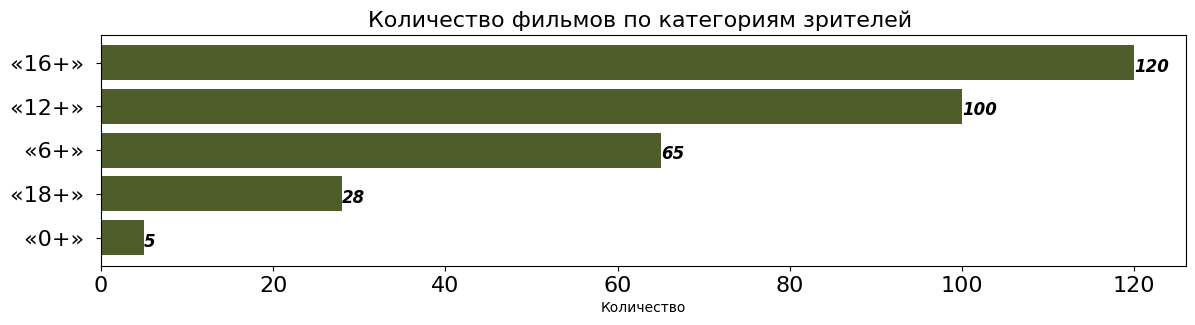

In [129]:
barh_data_2 = data2.groupby('age_group')['box_office'].count().sort_values()
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
fig = plt.figure(figsize=(14,3))
ax = fig.add_subplot()
ax.barh( barh_data_2.index.values, barh_data_2,color=color[0])
#Оформление
ax.set_title('Количество фильмов по категориям зрителей ',size=16) 
ax.set_xlabel('Количество')
#ax.yaxis.set_tick_params(labelsize=20)
ax.tick_params(axis='both',labelsize=16)
#Надписи
rects = ax.patches
for bar in rects:    
    width = bar.get_width()    
    ax.text(width, bar.get_y()+0.2, str(round(width, 2)),fontsize='large', style='oblique',
            weight='bold', color='k',ha='left') 
plt.show()

### Cборы по категориям 

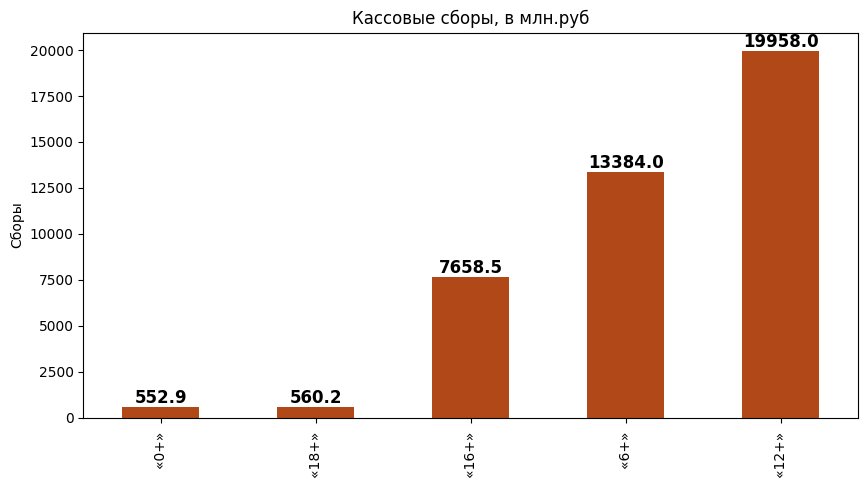

In [130]:
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) ]
fig,axes = plt.subplots(figsize=(10,5))
barh1_data_2 = data2.groupby('age_group')['revenue_mln'].sum().sort_values().plot(
    kind = 'bar', ylabel = 'Сборы', xlabel='', color = color, title = 'Кассовые сборы, в млн.руб')
rects = axes.patches
for rect in rects:    
    height = rect.get_height()    
    axes.text(rect.get_x() + rect.get_width() / 2, height + 2, round(height,1),
        ha="center", va="bottom",weight='bold',size='large',c='black')
plt.show()

### Медианные и средние кассовые сборы по категориям зрителей

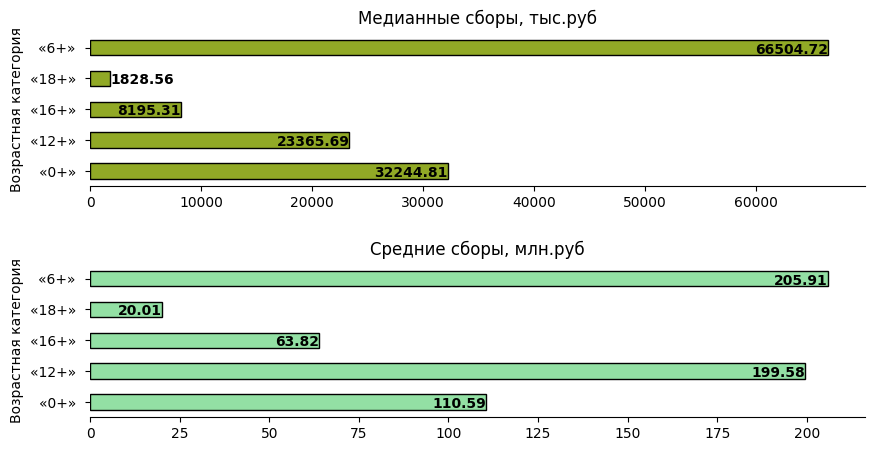

In [131]:
fig,axes = plt.subplots(2,1,figsize=(10,5))
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
# Диаграмма медианных сборов
gd_median_revenue = data2.pivot_table(
    index='age_group',values='revenue_1000',aggfunc ='median').plot(
    kind='barh',ax=axes[0],edgecolor='black',color = color,  
    title = 'Медианные сборы, тыс.руб', xlabel = 'Возрастная категория',legend=False)
axes[0].spines['top'].set_visible(False);axes[0].spines['right'].set_visible(False);
axes[0].spines['left'].set_visible(False)
# Диаграмма средних сборов
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
gd_mean_revenue = data2.pivot_table(
    index='age_group',values='revenue_mln',aggfunc ='mean').plot(
    kind='barh',ax=axes[1],edgecolor='black',color = color,
    title = 'Средние сборы, млн.руб',  xlabel = 'Возрастная категория',legend=False)
axes[1].spines['top'].set_visible(False);axes[1].spines['right'].set_visible(False);
axes[1].spines['left'].set_visible(False)  
# Надписи на первом графике
rects = axes[0].patches
for index in   range(len(rects)):    
    if index==3:
        width = rects[index].get_width()
        axes[0].text(width+0.5, rects[index].get_y()+0.2, str(round(width, 2)),
                 fontsize='medium', weight='bold', color='black',va='center')
    else:
        width = rects[index].get_width()    
        axes[0].text(width, rects[index].get_y()+0.2, str(round(width, 2)),
                 fontsize='medium', weight='bold', color='black',ha='right',va='center') 
#Надписи на втором графике
rects = axes[1].patches
for bar in rects:    
    width = bar.get_width()    
    axes[1].text(width, bar.get_y()+0.2, str(round(width, 2)),
                 fontsize='medium', weight='bold', color='black',ha='right',va='center')
plt.subplots_adjust(hspace=0.5)
plt.show()   

In [132]:
print(199.5/23.3)
print(206/66.5)

8.562231759656653
3.0977443609022557


Можно сделать вывод, что фильмы для зрителей 6+ более предсказуемы в плане ожидаемых кассовых сборов, так как разрыв между этими двумя показателями составляет всего 3.Фильмы для всех зрителей также имеют такое свойство, но их выпустили всего 5 штук.

### Бюджет и сборы

In [133]:
avg_budget = data2['budget'].mean()
avg_govhelp = data2['goverment'].mean()
print('Средний бюджет фильма: ',round(avg_budget))
print('Средний размер поддержки: ',round(avg_govhelp))

Средний бюджет фильма:  132006722
Средний размер поддержки:  60726944


В среднем, господдержка составляет чуть больше половины бюджета фильмов.

### Кассовые сборы на 1 рубль господдержки

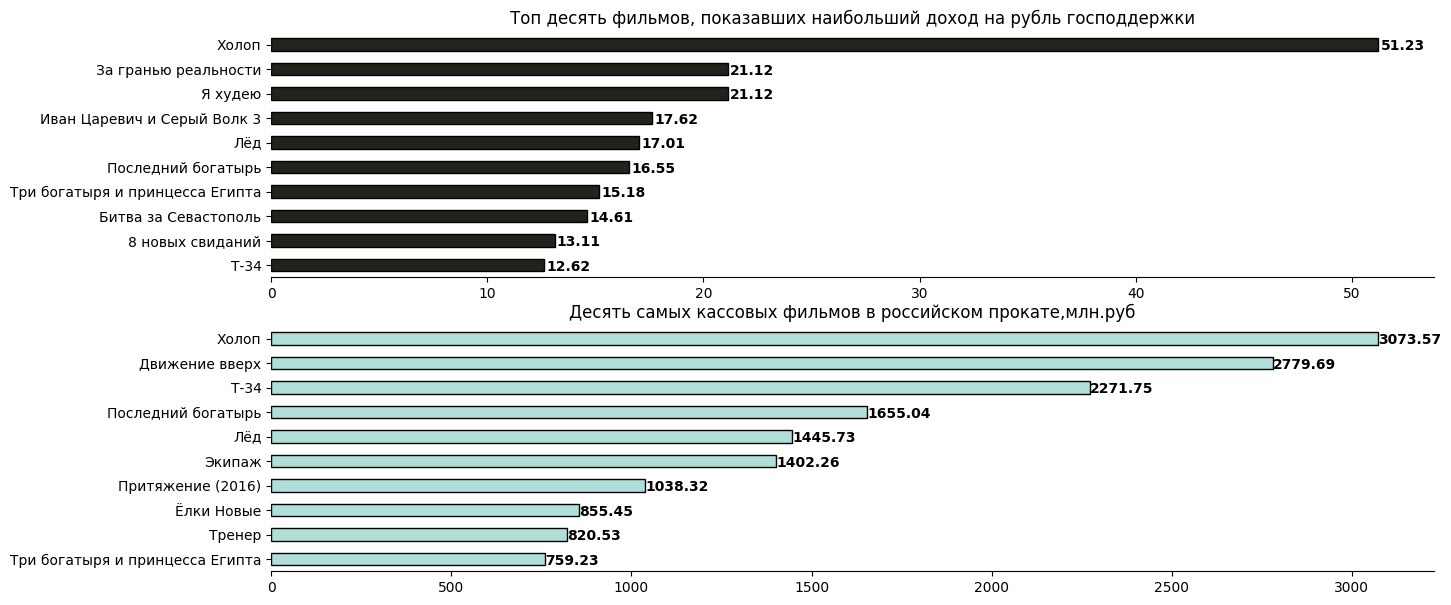

In [134]:
data2['revenue_1rub'] = data2['box_office']/data2['goverment']
cols = 1
rows = 2
count = 0
barh_data_3 = data2.groupby('title')['revenue_1rub'].sum().sort_values(ascending=True).tail(10)
barh_data_4 =  data2.groupby('title')['revenue_mln'].sum().sort_values().tail(10)
dfs = [barh_data_3,barh_data_4]
titles = ['Топ десять фильмов, показавших наибольший доход на рубль господдержки',
         'Десять самых кассовых фильмов в российском прокате,млн.руб']
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,7))
#Построение графиков, отсортированных по возрастанию
for r in range(rows):                
            color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
            ax = dfs[count].plot(
                kind='barh',ax=axes[r], edgecolor='black',  color = color, grid=False,
                title = titles[count], xlabel = '',legend=False)
            #Убирание рамок вложенных графиков           
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            #Нанесение надписей
            rects = axes[r].patches
            for index in range(len(rects)):
                width = rects[index].get_width()
                t = axes[r].text(width+0.1, rects[index].get_y()+0.2, str(round(width, 2)),
                          fontsize='medium', weight='bold', color='black',va='center',ha='left')
            count+=1
plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.show()

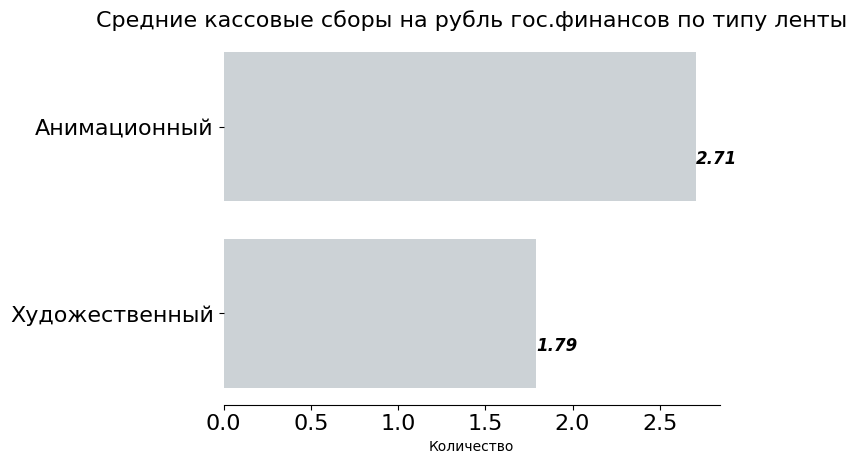

In [135]:
barh_data_6 = data2.groupby('type')['revenue_1rub'].mean().sort_values().tail(10)
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
fig = plt.figure()
ax = fig.add_subplot()
ax.barh( barh_data_6.index.values, barh_data_6,color=color[0])
#Оформление
ax.set_title('Средние кассовые сборы на рубль гос.финансов по типу ленты',size=16) 
ax.set_xlabel('Количество')
ax.tick_params(axis='both',labelsize=16)
 #Убирание рамок вложенных графиков           
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
#Надписи
rects = ax.patches
for bar in rects:    
    width = bar.get_width()    
    ax.text(width, bar.get_y()+0.2, str(round(width, 2)),fontsize='large', style='oblique',
            weight='bold', color='k',ha='left') 
plt.show()

В среднем кассовые сборы от анимационных фильмов лучше, чем от художественных. Поэтому в них следует больше вкладывать refundable_support.

### Студии, приносящие наибольшие сборы на рубль поддержки 

Создание функции для определения главного имени и приведем их к нижнему регистру, так как это позволит увеличить число совпадений при группировке.

In [136]:
def main_studio(studio):    
        temp = str(studio).split('по заказу')
        tmp = temp[0]       
        tmp1 = tmp.split(',')
        tmp2 = tmp1[0]
        tmp3 = tmp2.split(';')        
        new_name = tmp3[0]
        return new_name.lower()  

data2['main_studio'] = data2['film_studio'].apply(main_studio)

In [137]:
display(data2.sort_values('box_office',ascending=False)[['film_studio','main_studio']])

,film_studio,main_studio
7456,"ООО ""МЕМ-МЕДИА"" по заказу АО ""ВБД Груп""","ооо ""мем-медиа"""
5653,"ООО ""Студия ""ТРИТЭ"" Никиты Михалкова""","ооо ""студия ""тритэ"" никиты михалкова"""
6549,"ООО ""Кинокомпания МАРС-фильм"" по заказу ООО ""М...","ооо ""кинокомпания марс-фильм"""
5505,"ООО ""Киностудия ""Слово"" по заказу ООО ""Уолт Ди...","ооо ""киностудия ""слово"""
5708,"ООО ""Водород 2011"", ООО ""Арт Пикчерс Студия"", ...","ооо ""водород 2011"""
...,...,...
2150,"ООО ""Артлайт""","ооо ""артлайт"""
3504,"ООО ""Кинобюро"" по заказу ООО ""Среда и Ко""","ооо ""кинобюро"""
2803,"ООО ""КИНОДАНЦ"", ООО ""КИНОБАЙТ""","ооо ""киноданц"""
2527,"ООО ""Первое творческое объединение""","ооо ""первое творческое объединение"""


Создание диаграммы студий, приносящих наибольший доход на рубль поддержки:

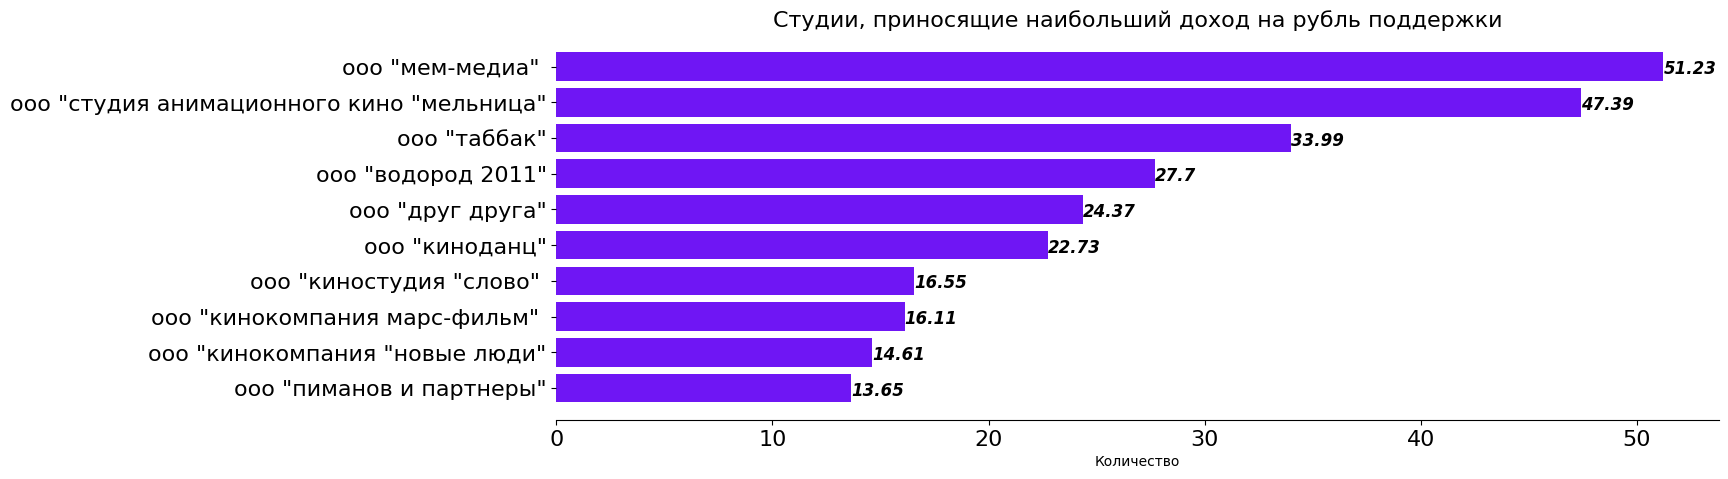

In [138]:
barh_data_5 = data2.groupby('main_studio')['revenue_1rub'].sum().sort_values().tail(10)
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot()
ax.barh( barh_data_5.index.values, barh_data_5,color=color[0])
#Оформление
ax.set_title('Студии, приносящие наибольший доход на рубль поддержки',size=16) 
ax.set_xlabel('Количество')
ax.tick_params(axis='both',labelsize=16)
 #Убирание рамок вложенных графиков           
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
#Надписи
rects = ax.patches
for bar in rects:    
    width = bar.get_width()    
    ax.text(width, bar.get_y()+0.2, str(round(width, 2)),fontsize='large', style='oblique',
            weight='bold', color='k',ha='left') 
plt.show()

Лучше всего государственными деньгами распоряжаются в студиях: ООО "Мем-Медиа",ООО "Студия анимационного кино "Мельница",ООО "ТаББак", ООО "Водород 2011", ООО "Друг друга" и ООО "Киноданц", имеющие рентабельность на вложенный капитал больше 20%.

### Кому чаще всего идут средства  

In [139]:
display(
    data2.groupby('main_studio').count()['box_office'].sort_values(ascending=False))

main_studio
ооо "таббак"                                    9
ооо "кинокомпания "ств"                         7
ооо "студия анимационного кино "мельница"       7
ооо "энджой мувиз"                              6
ооо "визарт фильм"                              5
                                               ..
ооо "кинопрограмма  "xxi век"                   1
ооо "кинопрограмма xxi век"                     1
ооо "кинопрогрупп"                              1
ооо "киностудия "арк-фильм"                     1
фонд поддержки развития общества "наши дети"    1
Name: box_office, Length: 207, dtype: int64

In [140]:
display(data2[data2['film_studio'].str.contains('ТаББаК') | (data2['film_studio'].str.contains('Мельница'))])

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,...,show_year,main_genre,main_director,gov_help_%,revenue_1000,revenue_mln,age_group,goverment,revenue_1rub,main_studio
5641,Ёлки Новые,111011617,2017-12-21 12:00:00+00:00,Художественный,"ООО ""ТаББаК""",Россия,"Д.Киселев, А.Першин (Ж.Крыжовников), А.Карпило...","Т.Бекмамбетов, Г.Стрижевская",«6+» - для детей старше 6 лет,"50,000,000.0",...,2017,комедия,Д.Киселев,57.35,"855,451.052",855.451052,«6+»,"100,000,000.0",8.55451052,"ооо ""таббак"""
5659,Три богатыря и принцесса Египта,114003317,2017-12-21 12:00:00+00:00,Анимационный,"ООО ""Студия анимационного кино ""Мельница""",Россия,К.Феоктистов,"С.Сельянов, А.Боярский",«6+» - для детей старше 6 лет,"50,000,000.0",...,2017,мультфильм,К.Феоктистов,28.66,"759,226.773",759.226773,«6+»,"50,000,000.0",15.18453546,"ооо ""студия анимационного кино ""мельница"""
3105,Иван Царевич и Серый Волк 3,114004115,2015-12-24 12:00:00+00:00,Анимационный,"ООО ""Студия анимационного кино ""Мельница""",Россия,Д.Шмидт,"С.Сельянов, А.Боярский",«6+» - для детей старше 6 лет,0.0,...,2015,мультфильм,Д.Шмидт,22.31,"704,928.216",704.928216,«6+»,"40,000,000.0",17.6232054,"ооо ""студия анимационного кино ""мельница"""
6509,Ёлки Последние,111023918,2018-12-10 12:00:00+00:00,Художественный,"ООО ""ТаББаК""",Россия,"Т.Бекмамбетов, А.Першин (псевдоним Ж.Крыжовник...","Т.Бекмамбетов, Г.Стрижевская",«6+» - для детей старше 6 лет,"75,000,000.0",...,2018,комедия,Т.Бекмамбетов,55.65,"701,507.03027",701.50703027,«6+»,"100,000,000.0",7.0150703027,"ооо ""таббак"""
2701,Самый Лучший День,111017815,2015-10-14 12:00:00+00:00,Художественный,"ООО ""ТаББаК""",Россия,А.Першин (псевдоним Ж.Крыжовников),"Т.Бекмамбетов, А.Першин (псевдоним Ж.Крыжовник...",«16+» - для детей старше 16 лет,"29,000,000.0",...,2015,комедия,А.Першин (псевдоним Ж.Крыжовников),48.23,"683,029.0614",683.0290613999999,«16+»,"63,000,000.0",10.841731133333333,"ооо ""таббак"""
6472,Три богатыря и наследница престола,114008818,2018-12-15 12:00:00+00:00,Анимационный,"ООО ""Студия анимационного кино ""Мельница""",Россия,К.Бронзит,"С.Сельянов, А.Боярский",«6+» - для детей старше 6 лет,"115,000,000.0",...,2018,мультфильм,К.Бронзит,61.99,"577,368.85325",577.36885325,«6+»,"115,000,000.0",5.020598723913044,"ооо ""студия анимационного кино ""мельница"""
3255,Время первых (2017),111001317,2017-02-21 12:00:00+00:00,Художественный,"ООО ""ТаББаК"", ООО ""Студия Третий Рим""",Россия,Д.Киселев,"Т.Бекмамбетов, Е.Миронов",«6+» - для детей старше 6 лет,"75,000,000.0",...,2017,приключения,Д.Киселев,47.31,"544,332.26",544.33226,«6+»,"250,000,000.0",2.17732904,"ооо ""таббак"""
7466,Иван Царевич и Серый Волк 4,114005019,2019-12-20 12:00:00+00:00,Анимационный,"ООО ""Студия анимационного кино ""Мельница""",Россия,"Д.Шмидт, К.Феоктистов","С.Сельянов, А.Боярский",«6+» - для детей старше 6 лет,"100,000,000.0",...,2019,мультфильм,Д.Шмидт,52.63,"501,069.235",501.069235,«6+»,"100,000,000.0",5.01069235,"ооо ""студия анимационного кино ""мельница"""
3610,Ёлки 5,111018016,2016-12-15 12:00:00+00:00,Художественный,"ООО ""ТаББаК""",Россия,"Т.Бекмамбетов, И.Джендубаев, А.Котт, А.Шавкеро...","Т.Бекмамбетов, И.Стромилова, М.Затуловская",«6+» - для детей старше 6 лет,0.0,...,2016,семейный,Т.Бекмамбетов,69.71,"308,401.4827",308.4014827,«6+»,"150,000,000.0",2.0560098846666666,"ооо ""таббак"""
3687,Урфин Джюс и его деревянные солдаты,114000817,2017-04-06 12:00:00+00:00,Анимационный,"ООО ""Студия анимационного кино ""Мельница""",Россия,"Д.Шмидт, Ф.Дмитриев, В.Торопчин","С.Сельянов, А.Боярский",«0+» - для любой зрительской аудитории,0.0,...,2017,мультфильм,Д.Шмидт,21.75,"206,478.186",206.478186,«0+»,"75,000,000.0",2.75304248,"ооо ""студия анимационного кино ""мельница"""


In [141]:
df_1 = data2.groupby('main_studio')['revenue_1rub'].sum().sort_values()
display (df_1[df_1.index.str.contains('"ств"') 
              | df_1.index.str.contains('визарт') 
              | df_1.index.str.contains('энджой')])

main_studio
ооо "кинокомпания "ств"   3.6588890595481476
ооо "визарт фильм"         9.175895889252978
ооо "энджой мувиз"               10.96300875
Name: revenue_1rub, dtype: float64

Чаще всего получателями поддержки были: ООО "Мем-Медиа",ООО "Студия анимационного кино "Мельница",ООО "Кинокомпания "СТВ",ООО "ВИЗАРТ ФИЛЬМ",ООО "Энджой мувиз". Но ООО "Кинокомпания "СТВ" имеет маленький показатель дохода на рубль гос.финансов (3.65 рубля).

### Количество выпущенных фильмов по виду поддержки 

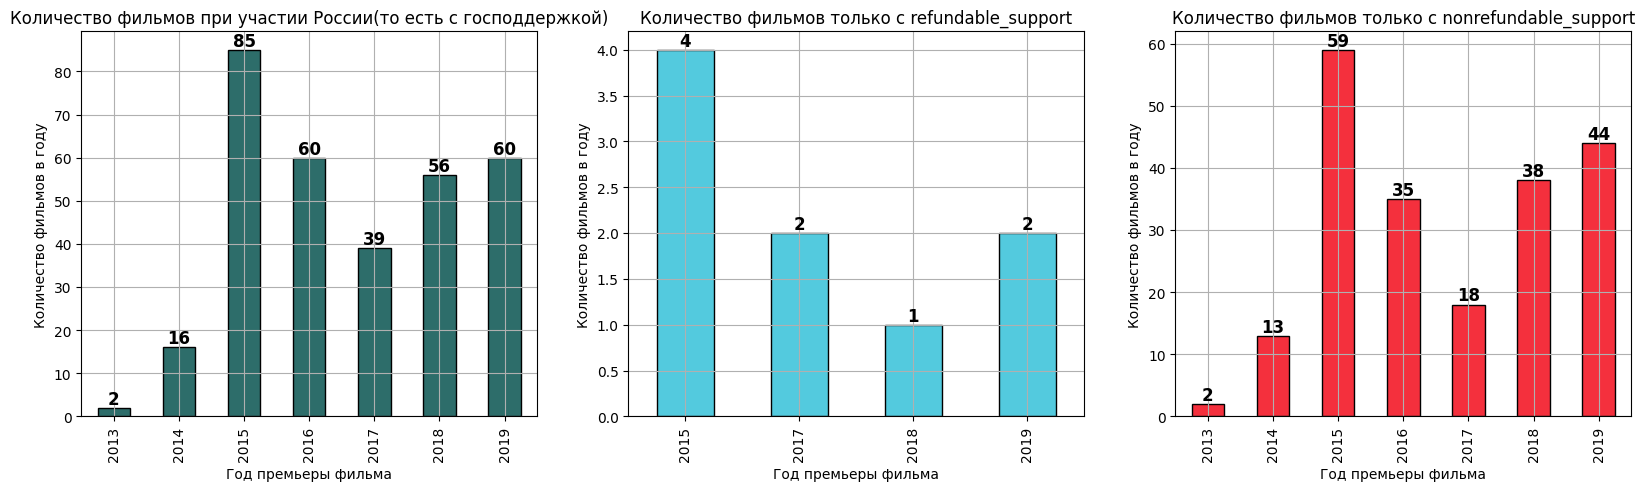

In [142]:
fig,axes = plt.subplots(1,3,figsize=(20,5),sharey=False)
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])] #генератор цвета
data2[data2['production_country'].str.contains('Россия')].groupby('show_year')['title'].count().plot.bar(
    ax=axes[0], edgecolor='black',grid=True, color=color)

color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
data2[data2['production_country'].str.contains('Россия')].query('nonrefundable_support==0').groupby('show_year')['title'].count().plot.bar(
    ax=axes[1], edgecolor='black',grid=True, color=color)

color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
data2[data2['production_country'].str.contains('Россия')].query('refundable_support==0').groupby('show_year')['title'].count().plot.bar(
    ax=axes[2], edgecolor='black',grid=True, color=color)

axes[0].set_title('Количество фильмов при участии России(то есть с господдержкой)')
axes[0].set_xlabel("Год премьеры фильма")
axes[0].set_ylabel("Количество фильмов в году")
axes[1].set_title('Количество фильмов только с refundable_support')
axes[1].set_xlabel("Год премьеры фильма")
axes[1].set_ylabel("Количество фильмов в году")
axes[2].set_title('Количество фильмов только с nonrefundable_support')
axes[2].set_xlabel("Год премьеры фильма")
axes[2].set_ylabel("Количество фильмов в году")
#Нанесение надписей
for index in range(len(axes)):
    rects = axes[index].patches
    for rect in rects:    
            height = rect.get_height()    
            axes[index].text(rect.get_x() + rect.get_width() / 2, height, round(height,1),
            ha="center", va="bottom",weight='bold',size='large',c='black')
plt.show()

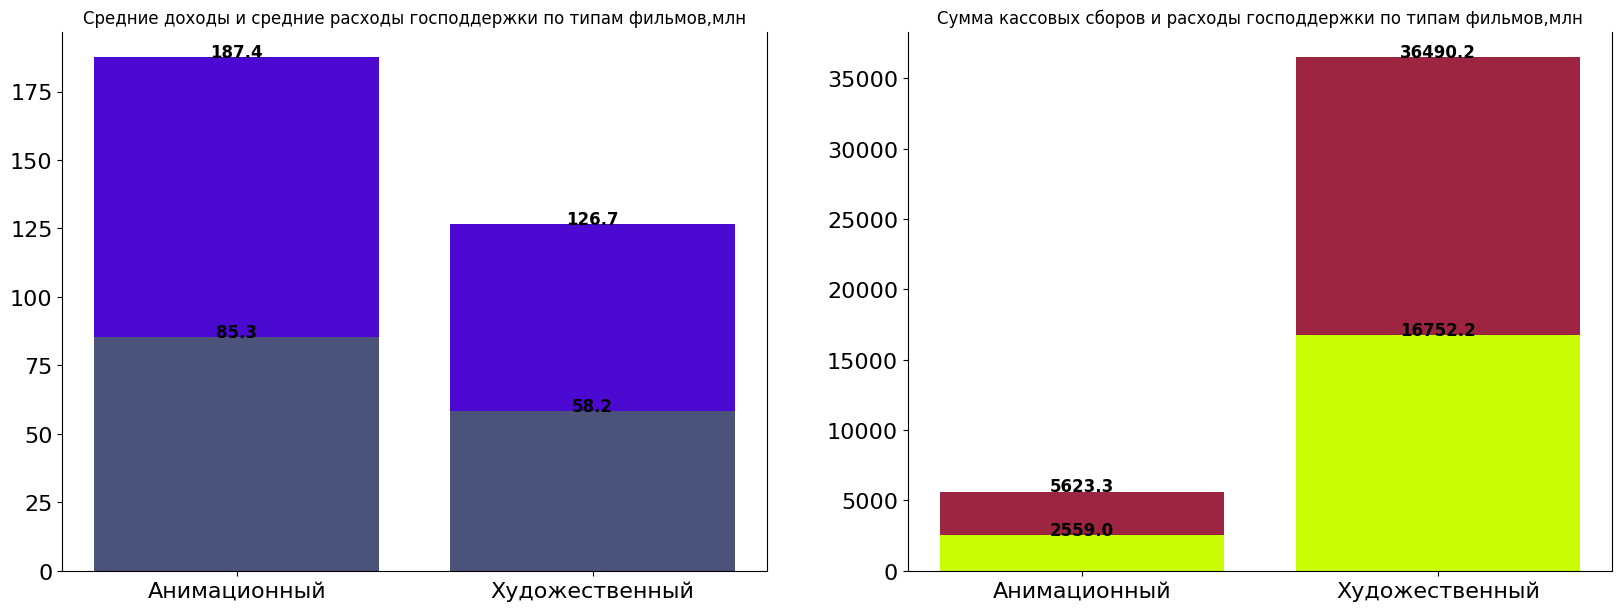

In [143]:
#Данные
data2['goverment_mln'] = data2['goverment']/1000000
plot_data_2 = data2.pivot_table(index = 'type',values = ['revenue_mln','goverment_mln'],aggfunc='mean')
plot_data_3 = data2.pivot_table(index = 'type',values = ['revenue_mln','goverment_mln'],aggfunc='sum')

fig, axes = plt.subplots(1,2, figsize=(20,7))
#график 1
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
axes[0].bar( plot_data_2.index.values, plot_data_2['revenue_mln'],color=color[0])
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
axes[0].bar( plot_data_2.index.values, plot_data_2['goverment_mln'],color=color[0])
## Оформление
axes[0].set_title('Средние доходы и средние расходы господдержки по типам фильмов,млн',size=12) 
axes[0].tick_params(axis='both',labelsize=16)           
axes[0].spines['top'].set_visible(False);ax.spines['right'].set_visible(False)
## надписи 1
rects = axes[0].patches
for rect in rects:    
    height = rect.get_height()    
    axes[0].text(rect.get_x() + rect.get_width() / 2, height, round(height,1),
        ha="center", weight='bold',size='large',c='black')
#График 2
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
axes[1].bar( plot_data_3.index.values, plot_data_3['revenue_mln'],color=color[0])
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
axes[1].bar( plot_data_3.index.values, plot_data_3['goverment_mln'],color=color[0])
## Оформление 2
axes[1].set_title('Сумма кассовых сборов и расходы господдержки по типам фильмов,млн',size=12) 
axes[1].tick_params(axis='both',labelsize=16)           
axes[1].spines['top'].set_visible(False);ax.spines['right'].set_visible(False)
## надписи 2
rects = axes[1].patches
for rect in rects:    
    height = rect.get_height()    
    axes[1].text(rect.get_x() + rect.get_width() / 2,height,  round(height,1),
        ha="center", weight='bold',size='large',c='black')
plt.show()

### Рейтинг фильмов

Вывод статистики:

In [144]:
print(data2['ratings'].describe().round(1))

count   318.0
mean      5.7
std       1.7
min       0.0
25%       5.2
50%       6.2
75%       6.7
max       9.4
Name: ratings, dtype: float64


In [145]:
#Средний рейтинг
data2['ratings'].mean()

5.736477987421383

Средний рейтинг российских фильмов в базе данных на настоящий момент составляет 5.7.

### Корреляция количественных данных 

(6.0, 1.0)

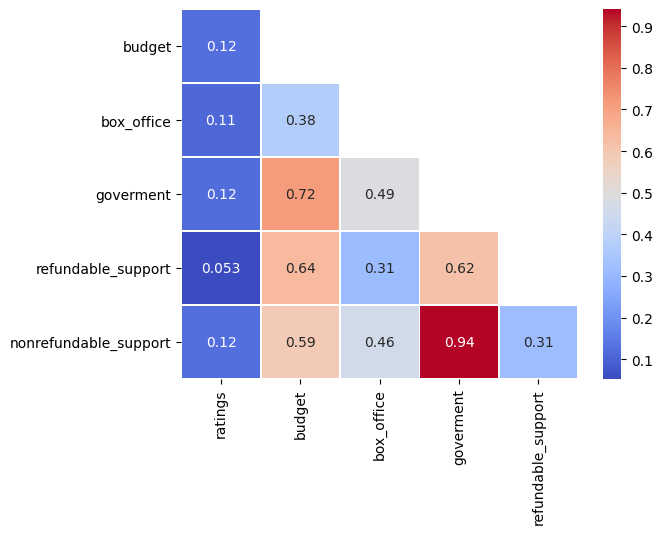

In [146]:
#Матрица корреляции
corr =  data2[['ratings','budget','box_office','goverment','refundable_support',
           'nonrefundable_support']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
ax = sns.heatmap(corr, annot = True, fmt='.2g', cmap= 'coolwarm', linewidths=.5, mask=mask)
ax.set_xlim(0,5)
ax.set_ylim(6,1)

Из матрицы корреляции видно, что nonrefundable_suppport коррелирует сильно больше с размером господдержки, чем refundable_support, значит она чаще встречается и ее размер больше. Бюджет фильма имеет высокую положительную корреляцию с господдержкой. А вот кассовые сборы слабо коррелируют с размером бюджета фильмов. Рейтинги также очень слабо коррелируют с другими количественными показателями.

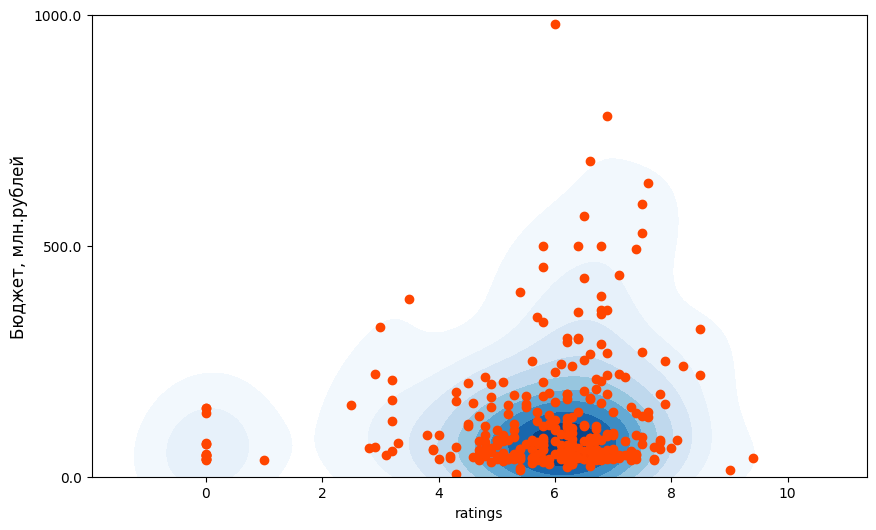

In [147]:
fig, ax = plt.subplots(1, figsize=(10,6))
kde_ratings = sns.kdeplot(data2.ratings, data2.budget/1000000, cmap='Blues',
           shade=True, shade_lowest=False)
plt.yticks(kde_ratings.get_yticks(), kde_ratings.get_yticks())
plt.ylabel('Бюджет, млн.рублей', fontsize=12)
plt.scatter(data2.ratings, data2.budget/1000000, color='orangered')
plt.ylim(0,1000)
plt.show()

In [148]:
display(data2[data2['budget']==data2['budget'].max()][['title','ratings','budget','box_office','goverment','refundable_support',
           'nonrefundable_support']])

,title,ratings,budget,box_office,goverment,refundable_support,nonrefundable_support
7114,Тайна Печати Дракона,5.8,"2,305,074,303.0","333,597,059.59","270,000,000.0","180,000,000.0","90,000,000.0"


Из кде графика видно, что бюджет основной массы фильмов составляет где-то 100 млн. рублей и его размер слабо коррелирует с рейтингом фильма.

### Вывод по разделу 3.

В результате исследования отчественных фильмов я посчитал, сколько выходило фильмов с разным типом гос.поддержки по годам, сколько выходило фильмов по каждой категории зрителей. Были рассчитаны показатели кассовых сборов и их медианных и средних значений, доходности по типам лент, анимационным и художественным, и сделаны соответствующие выводы. Были исследованы зависимости между количественными показателями на примере матрицы корреляции и кде графика. Также были определены главные получатели средств господдержки и посчитаны показатели эффективности их применения.

## Вывод по проекту

В результате изучения объединенного датасета я могу сделать следующие выводы:        
1. С течением времени доля фильмов с известной информацией растет и в 2019 году составила 57%.     
2. В 2019 году в  прокат поступило 924 фильма. Средние сборы достигли своего максимума в 2017 году и составили 136   млн.рублей, затем начали снижаться до 91,3 млн. рублей в 2019 году из-за внешних факторов. Медианные сборы также были максимальными в 2017 году и составили почти 10 млн.рублей.    
3.Самыми кассовыми фильмами в российском прокате стали отечественные ленты "Холоп" и "Движение вверх".      
4. Фильмы 6+ и 12+ пользуются большой популярностью.,больше всего в прокате было лент для детей категории 16+ (2578) и 12+ (1510), затем идут фильмы для взрослых (1478). По кассовым сборам также первые три места занимают ленты для детей 16+, 12+ и 6+ категорий.      
5. Фильмы для всех зрителей 0+ до 2014 года включительно лидировали по медианным сборам, но замтем наступил перелом и фильмы, которые имеют более четкую ориентированность на зрительские сегменты, заняли первые места.
6. Средний рейтинг фильмов в базе данных равен 5.6.      
7. Государство больше поддерживает выпуск фильмов ориентированных на подрастающее поколение. Помощь была оказана в производстве фильмов 16+ (120 фильмов), 12+ (100 фильмов) и 6+ (65 фильмов) из 318 фильмов. Фильмы этих категорий приносят больше всего сборов.  
8. Самыми частыми получателями гос.финансирования являются студии "ТаББаК"(9 фильмов),"Мельница"(7), "Кинокомпания"СТВ"(7). 
9. Лучше всего государственными деньгами распоряжаются в студиях: ООО "Мем-Медиа",ООО "Студия анимационного кино "Мельница",ООО "ТаББак", ООО "Водород 2011", ООО "Друг друга" и ООО "Киноданц", имеющие рентабельность на вложенный капитал больше 20%.  
10. В анимационные фильмы можно вкладывать больше возвратных средств, так как в среднем они приносят большие сборы, чем художественные ленты.  
11.Бюджет фильма имеет высокую положительную корреляцию с господдержкой. А вот кассовые сборы слабо коррелируют с размером бюджета фильмов. Рейтинги также очень слабо коррелируют с другими количественными показателями.